# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_45677/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_45677/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_45677/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.2, "tau_b": 0.7 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [8]:
output = model.train(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=or

tensor(-20.4368) tensor(-20.4368) tensor(229.9315, grad_fn=<AddBackward0>) tensor(1.5527, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(244.1721, grad_fn=<AddBackward0>) tensor(1.5807, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(221.6612, grad_fn=<AddBackward0>) tensor(1.5523, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(224.4576, grad_fn=<AddBackward0>) tensor(1.5558, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(221.2822, grad_fn=<AddBackward0>) tensor(1.5606, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(228.2989, grad_fn=<AddBackward0>) tensor(1.5567, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(229.7888, grad_fn=<AddBackward0>) tensor(1.5634, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(240.2108, grad_fn=<AddBackward0>) tensor(1.5710, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(227.1097) tensor(1.5338)
tensor(-20.4368) tenso

  0%|          | 1/1000 [00:00<11:21,  1.47it/s]

tensor(-20.4368) tensor(-20.4368) tensor(242.7516) tensor(1.5440)
tensor(-20.4368) tensor(-20.4368) tensor(219.2537) tensor(1.5559)
tensor(-20.4368) tensor(-20.4368) tensor(211.7025) tensor(1.5330)
tensor(-20.4368) tensor(-20.4368) tensor(242.9143) tensor(1.5772)
tensor(-20.4368) tensor(-20.4368) tensor(243.0629) tensor(1.5487)
tensor(-20.4368) tensor(-20.4368) tensor(235.7482) tensor(1.5574)
tensor(-20.4368) tensor(-20.4368) tensor(240.8484) tensor(1.5550)
tensor(-20.4368) tensor(-20.4368) tensor(224.8875) tensor(1.5354)
tensor(-20.4368) tensor(-20.4368) tensor(228.1674) tensor(1.5637)
tensor(-20.4368) tensor(-20.4368) tensor(227.8781) tensor(1.5376)
tensor(-20.4368) tensor(-20.4368) tensor(221.2328) tensor(1.5534)
tensor(-20.4368) tensor(-20.4368) tensor(238.8056) tensor(1.5609)
tensor(-20.4368) tensor(-20.4368) tensor(228.7021) tensor(1.5723)
tensor(-20.4368) tensor(-20.4368) tensor(233.1251) tensor(1.5454)
[1/1000] train=235.4521  val=235.6352  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=

  0%|          | 2/1000 [00:01<11:20,  1.47it/s]

tensor(-20.4368) tensor(-20.4368) tensor(236.6297) tensor(1.5327)
tensor(-20.4368) tensor(-20.4368) tensor(214.0579) tensor(1.5474)
tensor(-20.4368) tensor(-20.4368) tensor(202.6015) tensor(1.5198)
tensor(-20.4368) tensor(-20.4368) tensor(236.5465) tensor(1.5680)
tensor(-20.4368) tensor(-20.4368) tensor(236.9863) tensor(1.5376)
tensor(-20.4368) tensor(-20.4368) tensor(225.9704) tensor(1.5499)
tensor(-20.4368) tensor(-20.4368) tensor(232.7576) tensor(1.5437)
tensor(-20.4368) tensor(-20.4368) tensor(215.6054) tensor(1.5243)
tensor(-20.4368) tensor(-20.4368) tensor(220.6536) tensor(1.5595)
tensor(-20.4368) tensor(-20.4368) tensor(221.4898) tensor(1.5268)
tensor(-20.4368) tensor(-20.4368) tensor(213.8617) tensor(1.5421)
tensor(-20.4368) tensor(-20.4368) tensor(231.9362) tensor(1.5533)
tensor(-20.4368) tensor(-20.4368) tensor(221.3674) tensor(1.5622)
tensor(-20.4368) tensor(-20.4368) tensor(224.6033) tensor(1.5319)
[2/1000] train=232.9756  val=232.7011  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=

  0%|          | 3/1000 [00:01<10:53,  1.53it/s]

tensor(-20.4368) tensor(-20.4368) tensor(205.3213) tensor(1.5340)
tensor(-20.4368) tensor(-20.4368) tensor(190.1870) tensor(1.5066)
tensor(-20.4368) tensor(-20.4368) tensor(226.3152) tensor(1.5522)
tensor(-20.4368) tensor(-20.4368) tensor(225.9930) tensor(1.5241)
tensor(-20.4368) tensor(-20.4368) tensor(213.3357) tensor(1.5334)
tensor(-20.4368) tensor(-20.4368) tensor(221.6883) tensor(1.5324)
tensor(-20.4368) tensor(-20.4368) tensor(203.1461) tensor(1.5109)
tensor(-20.4368) tensor(-20.4368) tensor(209.2657) tensor(1.5428)
tensor(-20.4368) tensor(-20.4368) tensor(211.3421) tensor(1.5151)
tensor(-20.4368) tensor(-20.4368) tensor(203.8305) tensor(1.5286)
tensor(-20.4368) tensor(-20.4368) tensor(222.3168) tensor(1.5397)
tensor(-20.4368) tensor(-20.4368) tensor(209.6107) tensor(1.5456)
tensor(-20.4368) tensor(-20.4368) tensor(214.3038) tensor(1.5207)
[3/1000] train=227.0033  val=229.7653  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530
tensor(-20.4368) tensor(-20.4368)

  0%|          | 4/1000 [00:02<10:36,  1.57it/s]

tensor(-20.4368) tensor(-20.4368) tensor(192.7942) tensor(1.5215)
tensor(-20.4368) tensor(-20.4368) tensor(173.7512) tensor(1.4931)
tensor(-20.4368) tensor(-20.4368) tensor(211.5363) tensor(1.5388)
tensor(-20.4368) tensor(-20.4368) tensor(211.4552) tensor(1.5115)
tensor(-20.4368) tensor(-20.4368) tensor(195.3971) tensor(1.5153)
tensor(-20.4368) tensor(-20.4368) tensor(206.2579) tensor(1.5181)
tensor(-20.4368) tensor(-20.4368) tensor(187.2946) tensor(1.4964)
tensor(-20.4368) tensor(-20.4368) tensor(194.6359) tensor(1.5259)
tensor(-20.4368) tensor(-20.4368) tensor(197.2259) tensor(1.5020)
tensor(-20.4368) tensor(-20.4368) tensor(189.1752) tensor(1.5159)
tensor(-20.4368) tensor(-20.4368) tensor(208.4848) tensor(1.5248)
tensor(-20.4368) tensor(-20.4368) tensor(193.7047) tensor(1.5329)
tensor(-20.4368) tensor(-20.4368) tensor(198.9007) tensor(1.5077)
[4/1000] train=222.9182  val=226.8303  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541
tensor(-20.4368) tensor(-20.4368)

  0%|          | 5/1000 [00:03<13:37,  1.22it/s]

tensor(-20.4368) tensor(-20.4368) tensor(186.1859) tensor(1.5023)
tensor(-20.4368) tensor(-20.4368) tensor(167.1364) tensor(1.4802)
tensor(-20.4368) tensor(-20.4368) tensor(175.3962) tensor(1.5064)
tensor(-20.4368) tensor(-20.4368) tensor(179.1894) tensor(1.4877)
tensor(-20.4368) tensor(-20.4368) tensor(170.0993) tensor(1.5015)
tensor(-20.4368) tensor(-20.4368) tensor(190.4880) tensor(1.5080)
tensor(-20.4368) tensor(-20.4368) tensor(173.2356) tensor(1.5181)
tensor(-20.4368) tensor(-20.4368) tensor(179.7706) tensor(1.4938)
[5/1000] train=222.9312  val=223.8951  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551
tensor(-20.4368) tensor(-20.4368) tensor(182.7310, grad_fn=<AddBackward0>) tensor(1.5150, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(196.1870, grad_fn=<AddBackward0>) tensor(1.5089, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(183.9990, grad_fn=<AddBackward0>) tensor(1.5170, grad_fn=<AddBackward0>)
tensor(-20.4368) tens

  1%|          | 6/1000 [00:04<13:51,  1.20it/s]

tensor(-20.4368) tensor(-20.4368) tensor(155.9800) tensor(1.4768)
[6/1000] train=223.6353  val=220.9594  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562
tensor(-20.4368) tensor(-20.4368) tensor(176.6272, grad_fn=<AddBackward0>) tensor(1.4967, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(123.6123, grad_fn=<AddBackward0>) tensor(1.4655, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(133.7618, grad_fn=<AddBackward0>) tensor(1.5010, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(153.8128, grad_fn=<AddBackward0>) tensor(1.4928, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(149.2995, grad_fn=<AddBackward0>) tensor(1.4767, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(161.1824, grad_fn=<AddBackward0>) tensor(1.4985, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(122.3982, grad_fn=<AddBackward0>) tensor(1.4566, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20

  1%|          | 7/1000 [00:05<14:06,  1.17it/s]

tensor(-20.4368) tensor(-20.4368) tensor(114.7348) tensor(1.4530)
tensor(-20.4368) tensor(-20.4368) tensor(132.0668) tensor(1.4636)
tensor(-20.4368) tensor(-20.4368) tensor(111.9226) tensor(1.4409)
tensor(-20.4368) tensor(-20.4368) tensor(122.8944) tensor(1.4681)
tensor(-20.4368) tensor(-20.4368) tensor(129.4165) tensor(1.4511)
tensor(-20.4368) tensor(-20.4368) tensor(117.6589) tensor(1.4634)
tensor(-20.4368) tensor(-20.4368) tensor(141.0513) tensor(1.4710)
tensor(-20.4368) tensor(-20.4368) tensor(117.5492) tensor(1.4789)
tensor(-20.4368) tensor(-20.4368) tensor(127.6555) tensor(1.4561)
[7/1000] train=217.0763  val=218.0227  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573
tensor(-20.4368) tensor(-20.4368) tensor(109.8727, grad_fn=<AddBackward0>) tensor(1.4608, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(175.4198, grad_fn=<AddBackward0>) tensor(1.4880, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(84.6295, grad_fn=<AddBackwar

  1%|          | 8/1000 [00:06<13:35,  1.22it/s]

tensor(-20.4368) tensor(-20.4368) tensor(83.9825) tensor(1.4401)
tensor(-20.4368) tensor(-20.4368) tensor(108.7345) tensor(1.4499)
tensor(-20.4368) tensor(-20.4368) tensor(81.7187) tensor(1.4550)
tensor(-20.4368) tensor(-20.4368) tensor(94.2062) tensor(1.4326)
[8/1000] train=217.2016  val=215.0854  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584
tensor(-20.4368) tensor(-20.4368) tensor(110.4992, grad_fn=<AddBackward0>) tensor(1.4551, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(99.3830, grad_fn=<AddBackward0>) tensor(1.4671, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(90.3618, grad_fn=<AddBackward0>) tensor(1.4229, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(66.7449, grad_fn=<AddBackward0>) tensor(1.4586, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(88.9459, grad_fn=<AddBackward0>) tensor(1.4462, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(67.1118, grad_fn=<AddBa

  1%|          | 9/1000 [00:06<13:09,  1.26it/s]

tensor(1.3865)
tensor(-20.4368) tensor(-20.4368) tensor(67.5443) tensor(1.4368)
tensor(-20.4368) tensor(-20.4368) tensor(65.5905) tensor(1.4091)
tensor(-20.4368) tensor(-20.4368) tensor(35.4184) tensor(1.4056)
tensor(-20.4368) tensor(-20.4368) tensor(56.7374) tensor(1.4146)
tensor(-20.4368) tensor(-20.4368) tensor(35.2264) tensor(1.3917)
tensor(-20.4368) tensor(-20.4368) tensor(49.1576) tensor(1.4255)
tensor(-20.4368) tensor(-20.4368) tensor(59.2974) tensor(1.4041)
tensor(-20.4368) tensor(-20.4368) tensor(44.8325) tensor(1.4144)
tensor(-20.4368) tensor(-20.4368) tensor(70.8456) tensor(1.4268)
tensor(-20.4368) tensor(-20.4368) tensor(40.3139) tensor(1.4289)
tensor(-20.4368) tensor(-20.4368) tensor(55.3916) tensor(1.4064)
[9/1000] train=213.9462  val=212.1473  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596
tensor(-20.4368) tensor(-20.4368) tensor(71.3322, grad_fn=<AddBackward0>) tensor(1.4272, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(63.2937

  1%|          | 10/1000 [00:07<13:43,  1.20it/s]

tensor(-20.4368) tensor(-20.4368) tensor(10.7522) tensor(1.3777)
[10/1000] train=207.1235  val=209.2086  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607
tensor(-20.4368) tensor(-20.4368) tensor(6.5673, grad_fn=<AddBackward0>) tensor(1.3898, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-29.5148, grad_fn=<AddBackward0>) tensor(1.3594, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(45.4504, grad_fn=<AddBackward0>) tensor(1.4067, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(31.3497, grad_fn=<AddBackward0>) tensor(1.4185, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(22.1733, grad_fn=<AddBackward0>) tensor(1.3907, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-27.4598, grad_fn=<AddBackward0>) tensor(1.3539, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(47.7348, grad_fn=<AddBackward0>) tensor(1.3980, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368)

  1%|          | 11/1000 [00:08<14:22,  1.15it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-51.8994) tensor(1.3599)
tensor(-20.4368) tensor(-20.4368) tensor(-136.6529) tensor(1.2933)
tensor(-20.4368) tensor(-20.4368) tensor(-13.0433) tensor(1.3546)
tensor(-20.4368) tensor(-20.4368) tensor(-27.5395) tensor(1.3752)
tensor(-20.4368) tensor(-20.4368) tensor(-82.5958) tensor(1.3243)
tensor(-20.4368) tensor(-20.4368) tensor(-28.3136) tensor(1.3824)
tensor(-20.4368) tensor(-20.4368) tensor(-32.3119) tensor(1.3504)
tensor(-20.4368) tensor(-20.4368) tensor(-67.9113) tensor(1.3487)
tensor(-20.4368) tensor(-20.4368) tensor(-42.5740) tensor(1.3537)
tensor(-20.4368) tensor(-20.4368) tensor(-66.0563) tensor(1.3315)
tensor(-20.4368) tensor(-20.4368) tensor(-48.3810) tensor(1.3741)
tensor(-20.4368) tensor(-20.4368) tensor(-34.0595) tensor(1.3468)
tensor(-20.4368) tensor(-20.4368) tensor(-51.2364) tensor(1.3574)
tensor(-20.4368) tensor(-20.4368) tensor(-22.9721) tensor(1.3727)
tensor(-20.4368) tensor(-20.4368) tensor(-61.2809) tensor(1.3733)
tensor(-2

  1%|          | 12/1000 [00:10<15:56,  1.03it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-69.1443) tensor(1.3211)
tensor(-20.4368) tensor(-20.4368) tensor(-81.8023) tensor(1.3451)
tensor(-20.4368) tensor(-20.4368) tensor(-143.7977) tensor(1.2889)
tensor(-20.4368) tensor(-20.4368) tensor(-86.0060) tensor(1.3514)
tensor(-20.4368) tensor(-20.4368) tensor(-91.2605) tensor(1.3169)
tensor(-20.4368) tensor(-20.4368) tensor(-129.5722) tensor(1.3156)
tensor(-20.4368) tensor(-20.4368) tensor(-102.0901) tensor(1.3187)
tensor(-20.4368) tensor(-20.4368) tensor(-126.7412) tensor(1.2969)
tensor(-20.4368) tensor(-20.4368) tensor(-107.0528) tensor(1.3437)
tensor(-20.4368) tensor(-20.4368) tensor(-90.2595) tensor(1.3140)
tensor(-20.4368) tensor(-20.4368) tensor(-108.9298) tensor(1.3251)
tensor(-20.4368) tensor(-20.4368) tensor(-79.7393) tensor(1.3411)
tensor(-20.4368) tensor(-20.4368) tensor(-122.1403) tensor(1.3419)
tensor(-20.4368) tensor(-20.4368) tensor(-97.5297) tensor(1.3121)
[12/1000] train=207.6786  val=203.3277  S_train=16 S_val=32 lr=[0.01,

  1%|▏         | 13/1000 [00:10<14:59,  1.10it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-157.2786) tensor(1.2811)
tensor(-20.4368) tensor(-20.4368) tensor(-198.2675) tensor(1.2774)
tensor(-20.4368) tensor(-20.4368) tensor(-168.5172) tensor(1.2801)
tensor(-20.4368) tensor(-20.4368) tensor(-194.5602) tensor(1.2586)
tensor(-20.4368) tensor(-20.4368) tensor(-172.8092) tensor(1.3078)
tensor(-20.4368) tensor(-20.4368) tensor(-153.3008) tensor(1.2781)
tensor(-20.4368) tensor(-20.4368) tensor(-173.4034) tensor(1.2906)
tensor(-20.4368) tensor(-20.4368) tensor(-143.4684) tensor(1.3051)
tensor(-20.4368) tensor(-20.4368) tensor(-190.1399) tensor(1.3087)
tensor(-20.4368) tensor(-20.4368) tensor(-161.7930) tensor(1.2755)
[13/1000] train=203.6505  val=200.3851  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644
tensor(-20.4368) tensor(-20.4368) tensor(-114.9775, grad_fn=<AddBackward0>) tensor(1.3148, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-163.1154, grad_fn=<AddBackward0>) tensor(1.2998, grad_fn=<AddB

  1%|▏         | 14/1000 [00:11<14:26,  1.14it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-202.2286) tensor(1.2454)
tensor(-20.4368) tensor(-20.4368) tensor(-210.9432) tensor(1.2759)
tensor(-20.4368) tensor(-20.4368) tensor(-287.9117) tensor(1.2118)
tensor(-20.4368) tensor(-20.4368) tensor(-222.3143) tensor(1.2821)
tensor(-20.4368) tensor(-20.4368) tensor(-230.6490) tensor(1.2431)
tensor(-20.4368) tensor(-20.4368) tensor(-274.3272) tensor(1.2339)
tensor(-20.4368) tensor(-20.4368) tensor(-242.2050) tensor(1.2379)
tensor(-20.4368) tensor(-20.4368) tensor(-269.7137) tensor(1.2167)
tensor(-20.4368) tensor(-20.4368) tensor(-245.8625) tensor(1.2662)
tensor(-20.4368) tensor(-20.4368) tensor(-223.4228) tensor(1.2394)
tensor(-20.4368) tensor(-20.4368) tensor(-244.9305) tensor(1.2542)
tensor(-20.4368) tensor(-20.4368) tensor(-214.4617) tensor(1.2646)
tensor(-20.4368) tensor(-20.4368) tensor(-265.6029) tensor(1.2741)
tensor(-20.4368) tensor(-20.4368) tensor(-233.2121) tensor(1.2366)
[14/1000] train=207.4742  val=197.4411  S_train=16 S_val=32 lr

  2%|▏         | 15/1000 [00:12<13:59,  1.17it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-311.7417) tensor(1.2004)
tensor(-20.4368) tensor(-20.4368) tensor(-358.1165) tensor(1.1872)
tensor(-20.4368) tensor(-20.4368) tensor(-323.4026) tensor(1.1928)
tensor(-20.4368) tensor(-20.4368) tensor(-352.5656) tensor(1.1713)
tensor(-20.4368) tensor(-20.4368) tensor(-326.4278) tensor(1.2214)
tensor(-20.4368) tensor(-20.4368) tensor(-300.9578) tensor(1.1971)
tensor(-20.4368) tensor(-20.4368) tensor(-323.8314) tensor(1.2132)
tensor(-20.4368) tensor(-20.4368) tensor(-293.0558) tensor(1.2207)
tensor(-20.4368) tensor(-20.4368) tensor(-348.6788) tensor(1.2335)
tensor(-20.4368) tensor(-20.4368) tensor(-312.1422) tensor(1.1940)
[15/1000] train=196.0991  val=194.4951  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669
tensor(-20.4368) tensor(-20.4368) tensor(-267.9010, grad_fn=<AddBackward0>) tensor(1.2319, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-385.8636, grad_fn=<AddBackward0>) tensor(1.1789, grad_fn=<AddB

  2%|▏         | 16/1000 [00:13<13:34,  1.21it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-365.0925) tensor(1.1564)
tensor(-20.4368) tensor(-20.4368) tensor(-369.1534) tensor(1.1903)
tensor(-20.4368) tensor(-20.4368) tensor(-462.8542) tensor(1.1188)
tensor(-20.4368) tensor(-20.4368) tensor(-388.6899) tensor(1.1941)
tensor(-20.4368) tensor(-20.4368) tensor(-400.8472) tensor(1.1524)
tensor(-20.4368) tensor(-20.4368) tensor(-449.9159) tensor(1.1368)
tensor(-20.4368) tensor(-20.4368) tensor(-412.4579) tensor(1.1443)
tensor(-20.4368) tensor(-20.4368) tensor(-443.4760) tensor(1.1219)
tensor(-20.4368) tensor(-20.4368) tensor(-414.8613) tensor(1.1731)
tensor(-20.4368) tensor(-20.4368) tensor(-386.2210) tensor(1.1506)
tensor(-20.4368) tensor(-20.4368) tensor(-410.4461) tensor(1.1667)
tensor(-20.4368) tensor(-20.4368) tensor(-379.5723) tensor(1.1731)
tensor(-20.4368) tensor(-20.4368) tensor(-439.7076) tensor(1.1858)
tensor(-20.4368) tensor(-20.4368) tensor(-398.8123) tensor(1.1471)
[16/1000] train=193.6226  val=191.5468  S_train=16 S_val=32 lr

  2%|▏         | 17/1000 [00:14<13:36,  1.20it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-459.9177) tensor(1.1404)
tensor(-20.4368) tensor(-20.4368) tensor(-562.6133) tensor(1.0650)
tensor(-20.4368) tensor(-20.4368) tensor(-483.9111) tensor(1.1415)
tensor(-20.4368) tensor(-20.4368) tensor(-498.3616) tensor(1.0994)
tensor(-20.4368) tensor(-20.4368) tensor(-550.0529) tensor(1.0825)
tensor(-20.4368) tensor(-20.4368) tensor(-509.6619) tensor(1.0923)
tensor(-20.4368) tensor(-20.4368) tensor(-542.6198) tensor(1.0685)
tensor(-20.4368) tensor(-20.4368) tensor(-511.4265) tensor(1.1207)
tensor(-20.4368) tensor(-20.4368) tensor(-479.5487) tensor(1.1001)
tensor(-20.4368) tensor(-20.4368) tensor(-505.0199) tensor(1.1153)
tensor(-20.4368) tensor(-20.4368) tensor(-474.3326) tensor(1.1215)
tensor(-20.4368) tensor(-20.4368) tensor(-539.0344) tensor(1.1320)
tensor(-20.4368) tensor(-20.4368) tensor(-493.6151) tensor(1.0960)
[17/1000] train=193.7065  val=188.5961  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696
tensor(-20.4368) t

  2%|▏         | 18/1000 [00:14<13:50,  1.18it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-641.3457) tensor(1.0425)
tensor(-20.4368) tensor(-20.4368) tensor(-779.6443) tensor(0.9418)
tensor(-20.4368) tensor(-20.4368) tensor(-560.1613) tensor(1.0521)
tensor(-20.4368) tensor(-20.4368) tensor(-558.8659) tensor(1.0863)
tensor(-20.4368) tensor(-20.4368) tensor(-671.1075) tensor(1.0068)
tensor(-20.4368) tensor(-20.4368) tensor(-587.5563) tensor(1.0842)
tensor(-20.4368) tensor(-20.4368) tensor(-604.5101) tensor(1.0419)
tensor(-20.4368) tensor(-20.4368) tensor(-658.9005) tensor(1.0242)
tensor(-20.4368) tensor(-20.4368) tensor(-615.2969) tensor(1.0364)
tensor(-20.4368) tensor(-20.4368) tensor(-650.3354) tensor(1.0111)
tensor(-20.4368) tensor(-20.4368) tensor(-616.3871) tensor(1.0645)
tensor(-20.4368) tensor(-20.4368) tensor(-581.2025) tensor(1.0455)
tensor(-20.4368) tensor(-20.4368) tensor(-607.9376) tensor(1.0594)
tensor(-20.4368) tensor(-20.4368) tensor(-577.5869) tensor(1.0659)
tensor(-20.4368) tensor(-20.4368) tensor(-646.9404) tensor(1.0

  2%|▏         | 19/1000 [00:15<14:11,  1.15it/s]

tensor(1.0097)
tensor(-20.4368) tensor(-20.4368) tensor(-708.8566) tensor(0.9816)
[19/1000] train=182.6998  val=182.6884  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723
tensor(-20.4368) tensor(-20.4368) tensor(-715.1534, grad_fn=<AddBackward0>) tensor(0.9817, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-770.9093, grad_fn=<AddBackward0>) tensor(0.9639, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-688.4597, grad_fn=<AddBackward0>) tensor(0.9943, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-680.9769, grad_fn=<AddBackward0>) tensor(1.0129, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-584.2019, grad_fn=<AddBackward0>) tensor(1.0632, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-743.6427, grad_fn=<AddBackward0>) tensor(0.9825, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-775.0482, grad_fn=<AddBackward0>) tensor(0.9772, grad_fn=<AddBackward0>)
te

  2%|▏         | 20/1000 [00:16<14:22,  1.14it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-885.7715) tensor(0.9165)
tensor(-20.4368) tensor(-20.4368) tensor(-1043.3875) tensor(0.8061)
tensor(-20.4368) tensor(-20.4368) tensor(-789.9386) tensor(0.9318)
tensor(-20.4368) tensor(-20.4368) tensor(-782.7245) tensor(0.9652)
tensor(-20.4368) tensor(-20.4368) tensor(-915.0142) tensor(0.8770)
tensor(-20.4368) tensor(-20.4368) tensor(-821.3783) tensor(0.9559)
tensor(-20.4368) tensor(-20.4368) tensor(-844.3157) tensor(0.9132)
tensor(-20.4368) tensor(-20.4368) tensor(-903.9366) tensor(0.8953)
tensor(-20.4368) tensor(-20.4368) tensor(-853.2103) tensor(0.9128)
tensor(-20.4368) tensor(-20.4368) tensor(-892.8497) tensor(0.8837)
tensor(-20.4368) tensor(-20.4368) tensor(-853.0927) tensor(0.9400)
tensor(-20.4368) tensor(-20.4368) tensor(-811.0927) tensor(0.9239)
tensor(-20.4368) tensor(-20.4368) tensor(-839.8248) tensor(0.9346)
tensor(-20.4368) tensor(-20.4368) tensor(-810.8773) tensor(0.9425)
tensor(-20.4368) tensor(-20.4368) tensor(-889.9038) tensor(0.

  2%|▏         | 21/1000 [00:17<15:55,  1.02it/s]

tensor(-20.4368) tensor(-20.4368) tensor(-918.6230) tensor(0.8650)
tensor(-20.4368) tensor(-20.4368) tensor(-908.2084) tensor(0.8984)
tensor(-20.4368) tensor(-20.4368) tensor(-1051.1526) tensor(0.8053)
tensor(-20.4368) tensor(-20.4368) tensor(-952.1794) tensor(0.8853)
tensor(-20.4368) tensor(-20.4368) tensor(-978.5562) tensor(0.8420)
tensor(-20.4368) tensor(-20.4368) tensor(-1040.8110) tensor(0.8247)
tensor(-20.4368) tensor(-20.4368) tensor(-986.1265) tensor(0.8445)
tensor(-20.4368) tensor(-20.4368) tensor(-1028.2673) tensor(0.8134)
tensor(-20.4368) tensor(-20.4368) tensor(-985.3712) tensor(0.8720)
tensor(-20.4368) tensor(-20.4368) tensor(-939.9337) tensor(0.8566)
tensor(-20.4368) tensor(-20.4368) tensor(-969.4567) tensor(0.8657)
tensor(-20.4368) tensor(-20.4368) tensor(-941.4906) tensor(0.8746)
tensor(-20.4368) tensor(-20.4368) tensor(-1025.5305) tensor(0.8684)
tensor(-20.4368) tensor(-20.4368) tensor(-960.4139) tensor(0.8498)
[21/1000] train=179.7369  val=176.7720  S_train=32 S_val=3

  2%|▏         | 22/1000 [00:19<17:52,  1.10s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-1171.0493) tensor(0.7938)
tensor(-20.4368) tensor(-20.4368) tensor(-1100.5544) tensor(0.7774)
[22/1000] train=177.3189  val=173.8103  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766
tensor(-20.4368) tensor(-20.4368) tensor(-1226.0469, grad_fn=<AddBackward0>) tensor(0.7310, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-963.1284, grad_fn=<AddBackward0>) tensor(0.8573, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1244.2996, grad_fn=<AddBackward0>) tensor(0.7162, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1028.8219, grad_fn=<AddBackward0>) tensor(0.8179, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1151.9290, grad_fn=<AddBackward0>) tensor(0.7850, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1285.9978, grad_fn=<AddBackward0>) tensor(0.6971, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1100.4784, grad_

  2%|▏         | 23/1000 [00:20<18:51,  1.16s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-1250.6216) tensor(0.7009)
[23/1000] train=172.8495  val=170.8460  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781
tensor(-20.4368) tensor(-20.4368) tensor(-1360.1338, grad_fn=<AddBackward0>) tensor(0.6672, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1377.9846, grad_fn=<AddBackward0>) tensor(0.6743, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1169.6566, grad_fn=<AddBackward0>) tensor(0.7631, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1292.5162, grad_fn=<AddBackward0>) tensor(0.6853, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1121.8301, grad_fn=<AddBackward0>) tensor(0.7814, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1175.2563, grad_fn=<AddBackward0>) tensor(0.7646, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1149.3152, grad_fn=<AddBackward0>) tensor(0.7588, grad_fn=<AddBackward0>)
tensor(-2

  2%|▏         | 24/1000 [00:21<19:52,  1.22s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-1363.4851) tensor(0.6365)
tensor(-20.4368) tensor(-20.4368) tensor(-1342.7400) tensor(0.6747)
tensor(-20.4368) tensor(-20.4368) tensor(-1519.8865) tensor(0.5690)
tensor(-20.4368) tensor(-20.4368) tensor(-1403.8679) tensor(0.6567)
tensor(-20.4368) tensor(-20.4368) tensor(-1442.2363) tensor(0.6070)
tensor(-20.4368) tensor(-20.4368) tensor(-1512.2605) tensor(0.5772)
tensor(-20.4368) tensor(-20.4368) tensor(-1444.1782) tensor(0.6067)
tensor(-20.4368) tensor(-20.4368) tensor(-1494.6331) tensor(0.5718)
tensor(-20.4368) tensor(-20.4368) tensor(-1441.9657) tensor(0.6325)
tensor(-20.4368) tensor(-20.4368) tensor(-1385.4985) tensor(0.6268)
tensor(-20.4368) tensor(-20.4368) tensor(-1416.2410) tensor(0.6413)
tensor(-20.4368) tensor(-20.4368) tensor(-1392.8538) tensor(0.6381)
tensor(-20.4368) tensor(-20.4368) tensor(-1492.8057) tensor(0.6395)
tensor(-20.4368) tensor(-20.4368) tensor(-1410.8650) tensor(0.6197)
[24/1000] train=167.7279  val=167.8794  S_train=

  2%|▎         | 25/1000 [00:23<19:56,  1.23s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-1507.8413) tensor(0.5917)
tensor(-20.4368) tensor(-20.4368) tensor(-1697.2614) tensor(0.4822)
tensor(-20.4368) tensor(-20.4368) tensor(-1575.1616) tensor(0.5737)
tensor(-20.4368) tensor(-20.4368) tensor(-1618.0991) tensor(0.5207)
tensor(-20.4368) tensor(-20.4368) tensor(-1690.6792) tensor(0.4834)
tensor(-20.4368) tensor(-20.4368) tensor(-1617.5898) tensor(0.5165)
tensor(-20.4368) tensor(-20.4368) tensor(-1671.1499) tensor(0.4810)
tensor(-20.4368) tensor(-20.4368) tensor(-1614.9980) tensor(0.5416)
tensor(-20.4368) tensor(-20.4368) tensor(-1554.6831) tensor(0.5406)
tensor(-20.4368) tensor(-20.4368) tensor(-1585.3955) tensor(0.5596)
tensor(-20.4368) tensor(-20.4368) tensor(-1564.0841) tensor(0.5485)
tensor(-20.4368) tensor(-20.4368) tensor(-1669.5825) tensor(0.5580)
tensor(-20.4368) tensor(-20.4368) tensor(-1581.6415) tensor(0.5339)
[25/1000] train=168.0874  val=164.9102  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0811
tenso

  3%|▎         | 26/1000 [00:24<20:05,  1.24s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-2086.4644) tensor(0.2678)
tensor(-20.4368) tensor(-20.4368) tensor(-1711.9656) tensor(0.4594)
tensor(-20.4368) tensor(-20.4368) tensor(-1683.6023) tensor(0.5030)
tensor(-20.4368) tensor(-20.4368) tensor(-1885.8381) tensor(0.3886)
tensor(-20.4368) tensor(-20.4368) tensor(-1757.4215) tensor(0.4840)
tensor(-20.4368) tensor(-20.4368) tensor(-1805.1580) tensor(0.4275)
tensor(-20.4368) tensor(-20.4368) tensor(-1880.2786) tensor(0.3856)
tensor(-20.4368) tensor(-20.4368) tensor(-1801.9153) tensor(0.4215)
tensor(-20.4368) tensor(-20.4368) tensor(-1858.7900) tensor(0.3848)
tensor(-20.4368) tensor(-20.4368) tensor(-1798.9756) tensor(0.4471)
tensor(-20.4368) tensor(-20.4368) tensor(-1734.7349) tensor(0.4488)
tensor(-20.4368) tensor(-20.4368) tensor(-1765.1836) tensor(0.4711)
tensor(-20.4368) tensor(-20.4368) tensor(-1746.2932) tensor(0.4544)
tensor(-20.4368) tensor(-20.4368) tensor(-1857.3711) tensor(0.4687)
tensor(-20.4368) tensor(-20.4368) tensor(-1763.3

  3%|▎         | 27/1000 [00:25<19:47,  1.22s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-1902.7327) tensor(0.3622)
tensor(-20.4368) tensor(-20.4368) tensor(-1870.3093) tensor(0.4086)
tensor(-20.4368) tensor(-20.4368) tensor(-2085.8416) tensor(0.2886)
tensor(-20.4368) tensor(-20.4368) tensor(-1950.8702) tensor(0.3881)
tensor(-20.4368) tensor(-20.4368) tensor(-2003.7032) tensor(0.3280)
tensor(-20.4368) tensor(-20.4368) tensor(-2081.3877) tensor(0.2830)
tensor(-20.4368) tensor(-20.4368) tensor(-1997.3975) tensor(0.3210)
tensor(-20.4368) tensor(-20.4368) tensor(-2057.8408) tensor(0.2830)
tensor(-20.4368) tensor(-20.4368) tensor(-1994.1753) tensor(0.3480)
tensor(-20.4368) tensor(-20.4368) tensor(-1925.9712) tensor(0.3513)
tensor(-20.4368) tensor(-20.4368) tensor(-1955.9180) tensor(0.3764)
tensor(-20.4368) tensor(-20.4368) tensor(-1939.7156) tensor(0.3553)
tensor(-20.4368) tensor(-20.4368) tensor(-2056.4753) tensor(0.3729)
tensor(-20.4368) tensor(-20.4368) tensor(-1956.0537) tensor(0.3440)
[27/1000] train=160.7792  val=158.9625  S_train=

  3%|▎         | 28/1000 [00:26<20:01,  1.24s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-2068.1975) tensor(0.3088)
tensor(-20.4368) tensor(-20.4368) tensor(-2297.4895) tensor(0.1828)
tensor(-20.4368) tensor(-20.4368) tensor(-2155.6794) tensor(0.2868)
tensor(-20.4368) tensor(-20.4368) tensor(-2213.9978) tensor(0.2227)
tensor(-20.4368) tensor(-20.4368) tensor(-2294.2842) tensor(0.1747)
tensor(-20.4368) tensor(-20.4368) tensor(-2204.2671) tensor(0.2148)
tensor(-20.4368) tensor(-20.4368) tensor(-2268.5352) tensor(0.1755)
tensor(-20.4368) tensor(-20.4368) tensor(-2200.8469) tensor(0.2436)
tensor(-20.4368) tensor(-20.4368) tensor(-2128.6455) tensor(0.2480)
tensor(-20.4368) tensor(-20.4368) tensor(-2157.8679) tensor(0.2764)
tensor(-20.4368) tensor(-20.4368) tensor(-2144.5854) tensor(0.2506)
tensor(-20.4368) tensor(-20.4368) tensor(-2267.1606) tensor(0.2717)
tensor(-20.4368) tensor(-20.4368) tensor(-2160.1428) tensor(0.2404)
[28/1000] train=158.3284  val=155.9839  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0859  σmax=0.0860
tenso

  3%|▎         | 29/1000 [00:28<19:46,  1.22s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-2277.6218) tensor(0.2026)
tensor(-20.4368) tensor(-20.4368) tensor(-2521.2385) tensor(0.0693)
tensor(-20.4368) tensor(-20.4368) tensor(-2372.3037) tensor(0.1781)
tensor(-20.4368) tensor(-20.4368) tensor(-2436.3994) tensor(0.1098)
tensor(-20.4368) tensor(-20.4368) tensor(-2519.3254) tensor(0.0619)
tensor(-20.4368) tensor(-20.4368) tensor(-2422.9253) tensor(0.1030)
tensor(-20.4368) tensor(-20.4368) tensor(-2491.2883) tensor(0.0619)
tensor(-20.4368) tensor(-20.4368) tensor(-2419.3337) tensor(0.1349)
tensor(-20.4368) tensor(-20.4368) tensor(-2343.1123) tensor(0.1384)
tensor(-20.4368) tensor(-20.4368) tensor(-2371.3428) tensor(0.1687)
tensor(-20.4368) tensor(-20.4368) tensor(-2361.2761) tensor(0.1408)
tensor(-20.4368) tensor(-20.4368) tensor(-2489.7583) tensor(0.1622)
tensor(-20.4368) tensor(-20.4368) tensor(-2375.9404) tensor(0.1299)
[29/1000] train=152.1115  val=153.0015  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876
tenso

  3%|▎         | 30/1000 [00:29<20:54,  1.29s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-2590.0120) tensor(0.0258)
tensor(-20.4368) tensor(-20.4368) tensor(-2724.4644) tensor(0.0444)
tensor(-20.4368) tensor(-20.4368) tensor(-2603.6914) tensor(0.0127)
[30/1000] train=153.7466  val=150.0155  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893
tensor(-20.4368) tensor(-20.4368) tensor(-2427.2771, grad_fn=<AddBackward0>) tensor(0.2740, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-2629.7659, grad_fn=<AddBackward0>) tensor(0.0186, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-2893.5005, grad_fn=<AddBackward0>) tensor(-0.1267, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-2783.9141, grad_fn=<AddBackward0>) tensor(-0.0791, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-2572.6687, grad_fn=<AddBackward0>) tensor(0.0391, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-2774.3691, grad_fn=<AddBackward0>) tensor(-0.0588, grad_fn=<A

  3%|▎         | 31/1000 [00:31<25:06,  1.55s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-2782.4587) tensor(-0.0874)
tensor(-20.4368) tensor(-20.4368) tensor(-2731.9954) tensor(-0.0290)
tensor(-20.4368) tensor(-20.4368) tensor(-3006.3442) tensor(-0.1808)
tensor(-20.4368) tensor(-20.4368) tensor(-2842.0964) tensor(-0.0613)
tensor(-20.4368) tensor(-20.4368) tensor(-2918.5283) tensor(-0.1383)
tensor(-20.4368) tensor(-20.4368) tensor(-3006.9873) tensor(-0.1784)
tensor(-20.4368) tensor(-20.4368) tensor(-2896.5828) tensor(-0.1377)
tensor(-20.4368) tensor(-20.4368) tensor(-2974.0425) tensor(-0.1835)
tensor(-20.4368) tensor(-20.4368) tensor(-2892.6982) tensor(-0.0962)
tensor(-20.4368) tensor(-20.4368) tensor(-2808.4946) tensor(-0.1000)
tensor(-20.4368) tensor(-20.4368) tensor(-2833.9766) tensor(-0.0687)
tensor(-20.4368) tensor(-20.4368) tensor(-2831.0933) tensor(-0.0945)
tensor(-20.4368) tensor(-20.4368) tensor(-2971.5969) tensor(-0.0813)
tensor(-20.4368) tensor(-20.4368) tensor(-2843.6914) tensor(-0.1112)
[31/1000] train=149.1274  val=147.

  3%|▎         | 32/1000 [00:34<28:41,  1.78s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-3231.4688) tensor(-0.2146)
tensor(-20.4368) tensor(-20.4368) tensor(-3096.2466) tensor(-0.2416)
[32/1000] train=148.5714  val=144.0331  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928
tensor(-20.4368) tensor(-20.4368) tensor(-2848.5825, grad_fn=<AddBackward0>) tensor(-0.0109, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3249.1782, grad_fn=<AddBackward0>) tensor(-0.2949, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3239.7500, grad_fn=<AddBackward0>) tensor(-0.3111, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3217.8579, grad_fn=<AddBackward0>) tensor(-0.3068, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3077.7339, grad_fn=<AddBackward0>) tensor(-0.2312, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3572.2683, grad_fn=<AddBackward0>) tensor(-0.4939, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-3225.38

  3%|▎         | 33/1000 [00:36<29:26,  1.83s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-3543.5693) tensor(-0.4609)
tensor(-20.4368) tensor(-20.4368) tensor(-3362.5635) tensor(-0.3299)
tensor(-20.4368) tensor(-20.4368) tensor(-3452.4343) tensor(-0.4156)
tensor(-20.4368) tensor(-20.4368) tensor(-3546.7356) tensor(-0.4383)
tensor(-20.4368) tensor(-20.4368) tensor(-3420.6030) tensor(-0.4004)
tensor(-20.4368) tensor(-20.4368) tensor(-3508.4102) tensor(-0.4526)
tensor(-20.4368) tensor(-20.4368) tensor(-3416.5537) tensor(-0.3459)
tensor(-20.4368) tensor(-20.4368) tensor(-3324.3579) tensor(-0.3631)
tensor(-20.4368) tensor(-20.4368) tensor(-3345.7937) tensor(-0.3350)
tensor(-20.4368) tensor(-20.4368) tensor(-3351.4575) tensor(-0.3505)
tensor(-20.4368) tensor(-20.4368) tensor(-3504.2925) tensor(-0.3571)
tensor(-20.4368) tensor(-20.4368) tensor(-3361.6145) tensor(-0.3786)
[33/1000] train=143.7578  val=141.0369  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0945  σmax=0.0946
tensor(-20.4368) tensor(-20.4368) tensor(-3471.6543, grad_fn=

  3%|▎         | 34/1000 [00:37<30:05,  1.87s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-3507.0588) tensor(-0.4231)
tensor(-20.4368) tensor(-20.4368) tensor(-3832.5464) tensor(-0.6087)
tensor(-20.4368) tensor(-20.4368) tensor(-3642.5117) tensor(-0.4719)
tensor(-20.4368) tensor(-20.4368) tensor(-3739.5396) tensor(-0.5621)
tensor(-20.4368) tensor(-20.4368) tensor(-3836.8811) tensor(-0.5798)
tensor(-20.4368) tensor(-20.4368) tensor(-3702.1665) tensor(-0.5416)
tensor(-20.4368) tensor(-20.4368) tensor(-3795.6465) tensor(-0.5969)
tensor(-20.4368) tensor(-20.4368) tensor(-3698.0791) tensor(-0.4822)
tensor(-20.4368) tensor(-20.4368) tensor(-3601.9434) tensor(-0.5036)
tensor(-20.4368) tensor(-20.4368) tensor(-3620.8547) tensor(-0.4752)
tensor(-20.4368) tensor(-20.4368) tensor(-3631.2830) tensor(-0.4891)
tensor(-20.4368) tensor(-20.4368) tensor(-3790.4009) tensor(-0.5013)
tensor(-20.4368) tensor(-20.4368) tensor(-3640.0962) tensor(-0.5205)
[34/1000] train=140.7737  val=138.0374  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax

  4%|▎         | 35/1000 [00:39<30:24,  1.89s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-3862.1260) tensor(-0.6357)
tensor(-20.4368) tensor(-20.4368) tensor(-3791.4209) tensor(-0.5663)
tensor(-20.4368) tensor(-20.4368) tensor(-4135.4077) tensor(-0.7614)
tensor(-20.4368) tensor(-20.4368) tensor(-3935.9526) tensor(-0.6188)
tensor(-20.4368) tensor(-20.4368) tensor(-4040.4575) tensor(-0.7140)
tensor(-20.4368) tensor(-20.4368) tensor(-4140.9546) tensor(-0.7306)
tensor(-20.4368) tensor(-20.4368) tensor(-3997.1528) tensor(-0.6903)
tensor(-20.4368) tensor(-20.4368) tensor(-4096.5977) tensor(-0.7487)
tensor(-20.4368) tensor(-20.4368) tensor(-3993.0476) tensor(-0.6278)
tensor(-20.4368) tensor(-20.4368) tensor(-3893.0435) tensor(-0.6508)
tensor(-20.4368) tensor(-20.4368) tensor(-3909.0283) tensor(-0.6200)
tensor(-20.4368) tensor(-20.4368) tensor(-3924.5374) tensor(-0.6359)
tensor(-20.4368) tensor(-20.4368) tensor(-4090.0840) tensor(-0.6492)
tensor(-20.4368) tensor(-20.4368) tensor(-3931.9204) tensor(-0.6683)
[35/1000] train=135.8263  val=135.

  4%|▎         | 36/1000 [00:41<30:56,  1.93s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-4452.5166) tensor(-0.9202)
tensor(-20.4368) tensor(-20.4368) tensor(-4243.1743) tensor(-0.7715)
tensor(-20.4368) tensor(-20.4368) tensor(-4355.5459) tensor(-0.8721)
tensor(-20.4368) tensor(-20.4368) tensor(-4459.3604) tensor(-0.8895)
tensor(-20.4368) tensor(-20.4368) tensor(-4305.8340) tensor(-0.8463)
tensor(-20.4368) tensor(-20.4368) tensor(-4411.6445) tensor(-0.9078)
tensor(-20.4368) tensor(-20.4368) tensor(-4301.7197) tensor(-0.7812)
tensor(-20.4368) tensor(-20.4368) tensor(-4197.9746) tensor(-0.8048)
tensor(-20.4368) tensor(-20.4368) tensor(-4210.6680) tensor(-0.7704)
tensor(-20.4368) tensor(-20.4368) tensor(-4231.5410) tensor(-0.7903)
tensor(-20.4368) tensor(-20.4368) tensor(-4403.6460) tensor(-0.8024)
tensor(-20.4368) tensor(-20.4368) tensor(-4237.4365) tensor(-0.8225)
[36/1000] train=136.7829  val=132.0266  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1001
tensor(-20.4368) tensor(-20.4368) tensor(-4268.6797, grad_fn=

  4%|▎         | 37/1000 [00:45<36:50,  2.30s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-4624.3252) tensor(-0.9445)
tensor(-20.4368) tensor(-20.4368) tensor(-4516.9121) tensor(-0.9658)
tensor(-20.4368) tensor(-20.4368) tensor(-4525.9434) tensor(-0.9249)
tensor(-20.4368) tensor(-20.4368) tensor(-4552.5454) tensor(-0.9536)
tensor(-20.4368) tensor(-20.4368) tensor(-4731.3115) tensor(-0.9578)
tensor(-20.4368) tensor(-20.4368) tensor(-4556.8501) tensor(-0.9826)
[37/1000] train=131.9164  val=129.0153  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1020  σmin=0.1020  σmax=0.1021
tensor(-20.4368) tensor(-20.4368) tensor(-4735.0918, grad_fn=<AddBackward0>) tensor(-1.0455, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4624.2051, grad_fn=<AddBackward0>) tensor(-0.9195, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4532.5093, grad_fn=<AddBackward0>) tensor(-0.9113, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4818.8999, grad_fn=<AddBackward0>) tensor(-1.1106, grad_fn=<AddBackward0>)
tensor(

  4%|▍         | 38/1000 [00:47<37:32,  2.34s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-4855.1646) tensor(-1.0860)
tensor(-20.4368) tensor(-20.4368) tensor(-4887.8555) tensor(-1.1239)
tensor(-20.4368) tensor(-20.4368) tensor(-5073.3770) tensor(-1.1201)
tensor(-20.4368) tensor(-20.4368) tensor(-4890.4971) tensor(-1.1496)
[38/1000] train=127.7914  val=126.0001  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040
tensor(-20.4368) tensor(-20.4368) tensor(-4386.4443, grad_fn=<AddBackward0>) tensor(-0.8839, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4492.8589, grad_fn=<AddBackward0>) tensor(-0.8736, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4856.2886, grad_fn=<AddBackward0>) tensor(-1.1169, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4852.5947, grad_fn=<AddBackward0>) tensor(-1.1199, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-4545.9058, grad_fn=<AddBackward0>) tensor(-0.9694, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.

  4%|▍         | 39/1000 [00:50<39:17,  2.45s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-5312.4771) tensor(-1.2925)
tensor(-20.4368) tensor(-20.4368) tensor(-5197.9502) tensor(-1.3087)
tensor(-20.4368) tensor(-20.4368) tensor(-5198.5830) tensor(-1.2540)
tensor(-20.4368) tensor(-20.4368) tensor(-5237.7007) tensor(-1.3016)
tensor(-20.4368) tensor(-20.4368) tensor(-5430.1064) tensor(-1.2898)
tensor(-20.4368) tensor(-20.4368) tensor(-5238.5947) tensor(-1.3234)
[39/1000] train=126.1862  val=122.9809  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1059  σmax=0.1060
tensor(-20.4368) tensor(-20.4368) tensor(-5149.9268, grad_fn=<AddBackward0>) tensor(-1.0724, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-5536.2124, grad_fn=<AddBackward0>) tensor(-1.4761, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-5318.0518, grad_fn=<AddBackward0>) tensor(-1.3532, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-5257.3765, grad_fn=<AddBackward0>) tensor(-1.3293, grad_fn=<AddBackward0>)
tensor(

  4%|▍         | 40/1000 [00:52<40:36,  2.54s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-5868.7998) tensor(-1.6136)
tensor(-20.4368) tensor(-20.4368) tensor(-5614.9165) tensor(-1.4390)
tensor(-20.4368) tensor(-20.4368) tensor(-5762.2393) tensor(-1.5650)
tensor(-20.4368) tensor(-20.4368) tensor(-5880.9727) tensor(-1.6118)
tensor(-20.4368) tensor(-20.4368) tensor(-5682.3711) tensor(-1.5456)
tensor(-20.4368) tensor(-20.4368) tensor(-5817.9424) tensor(-1.6196)
tensor(-20.4368) tensor(-20.4368) tensor(-5678.4702) tensor(-1.4794)
tensor(-20.4368) tensor(-20.4368) tensor(-5560.5698) tensor(-1.4904)
tensor(-20.4368) tensor(-20.4368) tensor(-5556.4424) tensor(-1.4264)
tensor(-20.4368) tensor(-20.4368) tensor(-5602.3418) tensor(-1.4877)
tensor(-20.4368) tensor(-20.4368) tensor(-5801.7632) tensor(-1.4627)
tensor(-20.4368) tensor(-20.4368) tensor(-5601.4463) tensor(-1.5033)
[40/1000] train=122.3147  val=119.9582  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1080  σmin=0.1080  σmax=0.1080
tensor(-20.4368) tensor(-20.4368) tensor(-5853.2075, grad_fn=

  4%|▍         | 41/1000 [00:56<46:55,  2.94s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-6274.9131) tensor(-1.8127)
tensor(-20.4368) tensor(-20.4368) tensor(-6063.3428) tensor(-1.7386)
tensor(-20.4368) tensor(-20.4368) tensor(-6207.5781) tensor(-1.8161)
tensor(-20.4368) tensor(-20.4368) tensor(-6059.5244) tensor(-1.6734)
tensor(-20.4368) tensor(-20.4368) tensor(-5938.3281) tensor(-1.6791)
tensor(-20.4368) tensor(-20.4368) tensor(-5929.0557) tensor(-1.6053)
tensor(-20.4368) tensor(-20.4368) tensor(-5982.1338) tensor(-1.6810)
tensor(-20.4368) tensor(-20.4368) tensor(-6188.6689) tensor(-1.6420)
tensor(-20.4368) tensor(-20.4368) tensor(-5979.3408) tensor(-1.6902)
[41/1000] train=120.5793  val=116.9317  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1100  σmax=0.1101
tensor(-20.4368) tensor(-20.4368) tensor(-5870.6035, grad_fn=<AddBackward0>) tensor(-1.6220, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-5439.3291, grad_fn=<AddBackward0>) tensor(-1.4238, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) 

  4%|▍         | 42/1000 [00:59<44:59,  2.82s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-6459.4258) tensor(-1.9387)
tensor(-20.4368) tensor(-20.4368) tensor(-6612.9238) tensor(-2.0200)
tensor(-20.4368) tensor(-20.4368) tensor(-6455.6846) tensor(-1.8736)
tensor(-20.4368) tensor(-20.4368) tensor(-6331.3662) tensor(-1.8754)
tensor(-20.4368) tensor(-20.4368) tensor(-6316.5029) tensor(-1.7923)
tensor(-20.4368) tensor(-20.4368) tensor(-6377.1499) tensor(-1.8811)
tensor(-20.4368) tensor(-20.4368) tensor(-6590.9487) tensor(-1.8301)
tensor(-20.4368) tensor(-20.4368) tensor(-6372.3887) tensor(-1.8849)
[42/1000] train=116.2148  val=113.9012  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1121  σmax=0.1122
tensor(-20.4368) tensor(-20.4368) tensor(-6416.7168, grad_fn=<AddBackward0>) tensor(-1.9040, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-6415.4727, grad_fn=<AddBackward0>) tensor(-1.8297, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-7106.2822, grad_fn=<AddBackward0>) tensor(-2.1958, grad_fn=<A

  4%|▍         | 43/1000 [01:01<41:02,  2.57s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-7094.5586) tensor(-2.2089)
tensor(-20.4368) tensor(-20.4368) tensor(-6801.3062) tensor(-2.0126)
tensor(-20.4368) tensor(-20.4368) tensor(-6978.6299) tensor(-2.1602)
tensor(-20.4368) tensor(-20.4368) tensor(-7110.9727) tensor(-2.2340)
tensor(-20.4368) tensor(-20.4368) tensor(-6871.0791) tensor(-2.1460)
tensor(-20.4368) tensor(-20.4368) tensor(-7034.4233) tensor(-2.2319)
tensor(-20.4368) tensor(-20.4368) tensor(-6867.4707) tensor(-2.0797)
tensor(-20.4368) tensor(-20.4368) tensor(-6740.1465) tensor(-2.0801)
tensor(-20.4368) tensor(-20.4368) tensor(-6719.2271) tensor(-1.9896)
tensor(-20.4368) tensor(-20.4368) tensor(-6787.7979) tensor(-2.0878)
tensor(-20.4368) tensor(-20.4368) tensor(-7009.0342) tensor(-2.0298)
tensor(-20.4368) tensor(-20.4368) tensor(-6781.0391) tensor(-2.0885)
[43/1000] train=113.5102  val=110.8658  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1143  σmin=0.1142  σmax=0.1143
tensor(-20.4368) tensor(-20.4368) tensor(-7254.5786, grad_fn=

  4%|▍         | 44/1000 [01:03<36:57,  2.32s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-7416.4580) tensor(-2.3773)
tensor(-20.4368) tensor(-20.4368) tensor(-7553.9160) tensor(-2.4553)
tensor(-20.4368) tensor(-20.4368) tensor(-7298.6592) tensor(-2.3610)
tensor(-20.4368) tensor(-20.4368) tensor(-7472.5000) tensor(-2.4520)
tensor(-20.4368) tensor(-20.4368) tensor(-7295.1689) tensor(-2.2929)
tensor(-20.4368) tensor(-20.4368) tensor(-7165.0293) tensor(-2.2932)
tensor(-20.4368) tensor(-20.4368) tensor(-7137.5835) tensor(-2.1957)
tensor(-20.4368) tensor(-20.4368) tensor(-7214.4517) tensor(-2.3021)
tensor(-20.4368) tensor(-20.4368) tensor(-7443.2822) tensor(-2.2392)
tensor(-20.4368) tensor(-20.4368) tensor(-7205.6318) tensor(-2.3006)
[44/1000] train=109.5356  val=107.8258  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1164  σmax=0.1165
tensor(-20.4368) tensor(-20.4368) tensor(-7154.9487, grad_fn=<AddBackward0>) tensor(-2.2665, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-7678.3662, grad_fn=<AddBackward0>) tenso

  4%|▍         | 45/1000 [01:04<33:53,  2.13s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-7994.0273) tensor(-2.6577)
tensor(-20.4368) tensor(-20.4368) tensor(-7671.5459) tensor(-2.4454)
tensor(-20.4368) tensor(-20.4368) tensor(-7870.8770) tensor(-2.6072)
tensor(-20.4368) tensor(-20.4368) tensor(-8013.7588) tensor(-2.6823)
tensor(-20.4368) tensor(-20.4368) tensor(-7742.2734) tensor(-2.5831)
tensor(-20.4368) tensor(-20.4368) tensor(-7927.2871) tensor(-2.6804)
tensor(-20.4368) tensor(-20.4368) tensor(-7738.9111) tensor(-2.5116)
tensor(-20.4368) tensor(-20.4368) tensor(-7606.1533) tensor(-2.5157)
tensor(-20.4368) tensor(-20.4368) tensor(-7571.6924) tensor(-2.4148)
tensor(-20.4368) tensor(-20.4368) tensor(-7657.2549) tensor(-2.5228)
tensor(-20.4368) tensor(-20.4368) tensor(-7893.8447) tensor(-2.4642)
tensor(-20.4368) tensor(-20.4368) tensor(-7646.3096) tensor(-2.5230)
[45/1000] train=107.2396  val=104.7801  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1187  σmin=0.1186  σmax=0.1187
tensor(-20.4368) tensor(-20.4368) tensor(-8151.5088, grad_fn=

  5%|▍         | 46/1000 [01:06<32:43,  2.06s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-8131.1406) tensor(-2.6810)
tensor(-20.4368) tensor(-20.4368) tensor(-8342.1367) tensor(-2.8494)
tensor(-20.4368) tensor(-20.4368) tensor(-8490.7578) tensor(-2.9145)
tensor(-20.4368) tensor(-20.4368) tensor(-8202.2031) tensor(-2.8121)
tensor(-20.4368) tensor(-20.4368) tensor(-8399.1006) tensor(-2.9170)
tensor(-20.4368) tensor(-20.4368) tensor(-8198.9443) tensor(-2.7351)
tensor(-20.4368) tensor(-20.4368) tensor(-8063.7451) tensor(-2.7472)
tensor(-20.4368) tensor(-20.4368) tensor(-8021.7939) tensor(-2.6465)
tensor(-20.4368) tensor(-20.4368) tensor(-8116.4863) tensor(-2.7497)
tensor(-20.4368) tensor(-20.4368) tensor(-8360.9980) tensor(-2.7042)
tensor(-20.4368) tensor(-20.4368) tensor(-8103.3389) tensor(-2.7556)
[46/1000] train=105.5505  val=101.7292  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1209  σmin=0.1208  σmax=0.1210
tensor(-20.4368) tensor(-20.4368) tensor(-7398.9014, grad_fn=<AddBackward0>) tensor(-2.1910, grad_fn=<AddBackward0>)
tensor(-20.43

  5%|▍         | 47/1000 [01:08<30:28,  1.92s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-8830.5049) tensor(-3.1010)
tensor(-20.4368) tensor(-20.4368) tensor(-8985.1602) tensor(-3.1529)
tensor(-20.4368) tensor(-20.4368) tensor(-8678.6338) tensor(-3.0483)
tensor(-20.4368) tensor(-20.4368) tensor(-8888.1504) tensor(-3.1613)
tensor(-20.4368) tensor(-20.4368) tensor(-8675.4990) tensor(-2.9646)
tensor(-20.4368) tensor(-20.4368) tensor(-8538.0459) tensor(-2.9868)
tensor(-20.4368) tensor(-20.4368) tensor(-8488.0586) tensor(-2.8874)
tensor(-20.4368) tensor(-20.4368) tensor(-8592.3740) tensor(-2.9830)
tensor(-20.4368) tensor(-20.4368) tensor(-8844.9678) tensor(-2.9542)
tensor(-20.4368) tensor(-20.4368) tensor(-8576.8799) tensor(-2.9967)
[47/1000] train=100.7527  val=98.6742  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1232  σmin=0.1231  σmax=0.1233
tensor(-20.4368) tensor(-20.4368) tensor(-9654.0176, grad_fn=<AddBackward0>) tensor(-3.5256, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-9168.2822, grad_fn=<AddBackward0>) tensor

  5%|▍         | 48/1000 [01:09<28:48,  1.82s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-9497.1924) tensor(-3.3992)
tensor(-20.4368) tensor(-20.4368) tensor(-9171.8086) tensor(-3.2921)
tensor(-20.4368) tensor(-20.4368) tensor(-9394.6396) tensor(-3.4135)
tensor(-20.4368) tensor(-20.4368) tensor(-9168.7725) tensor(-3.2012)
tensor(-20.4368) tensor(-20.4368) tensor(-9029.2969) tensor(-3.2339)
tensor(-20.4368) tensor(-20.4368) tensor(-8970.7031) tensor(-3.1356)
tensor(-20.4368) tensor(-20.4368) tensor(-9085.1377) tensor(-3.2238)
tensor(-20.4368) tensor(-20.4368) tensor(-9345.9512) tensor(-3.2114)
tensor(-20.4368) tensor(-20.4368) tensor(-9067.1748) tensor(-3.2455)
[48/1000] train=98.8740  val=95.6155  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1256  σmin=0.1254  σmax=0.1256
tensor(-20.4368) tensor(-20.4368) tensor(-9136.2393, grad_fn=<AddBackward0>) tensor(-3.2688, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10039.3887, grad_fn=<AddBackward0>) tensor(-3.6520, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) t

  5%|▍         | 49/1000 [01:11<28:28,  1.80s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-9859.5420) tensor(-3.6222)
tensor(-20.4368) tensor(-20.4368) tensor(-10027.1934) tensor(-3.6606)
tensor(-20.4368) tensor(-20.4368) tensor(-9681.9824) tensor(-3.5470)
tensor(-20.4368) tensor(-20.4368) tensor(-9918.8750) tensor(-3.6758)
tensor(-20.4368) tensor(-20.4368) tensor(-9679.0625) tensor(-3.4526)
tensor(-20.4368) tensor(-20.4368) tensor(-9537.7979) tensor(-3.4889)
tensor(-20.4368) tensor(-20.4368) tensor(-9470.1299) tensor(-3.3849)
tensor(-20.4368) tensor(-20.4368) tensor(-9594.9902) tensor(-3.4773)
tensor(-20.4368) tensor(-20.4368) tensor(-9864.2041) tensor(-3.4658)
tensor(-20.4368) tensor(-20.4368) tensor(-9574.4541) tensor(-3.4998)
[49/1000] train=96.2090  val=92.5529  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1279  σmin=0.1278  σmax=0.1280
tensor(-20.4368) tensor(-20.4368) tensor(-10798.6250, grad_fn=<AddBackward0>) tensor(-4.0495, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-9759.5254, grad_fn=<AddBackward0>) tenso

  5%|▌         | 50/1000 [01:13<28:43,  1.81s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-10098.9775) tensor(-3.7623)
[50/1000] train=92.1085  val=89.4856  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1304  σmin=0.1302  σmax=0.1304
tensor(-20.4368) tensor(-20.4368) tensor(-10532.6416, grad_fn=<AddBackward0>) tensor(-3.9526, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10378.4600, grad_fn=<AddBackward0>) tensor(-3.7749, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10642.0215, grad_fn=<AddBackward0>) tensor(-4.0221, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-9976.7744, grad_fn=<AddBackward0>) tensor(-3.6890, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10583.5449, grad_fn=<AddBackward0>) tensor(-3.9838, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10118.8047, grad_fn=<AddBackward0>) tensor(-3.7186, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-10239.9893, grad_fn=<AddBackward0>) tensor(-3.8178, grad_fn=<AddBackward

  5%|▌         | 51/1000 [05:45<21:50:24, 82.85s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-11842.8643) tensor(-4.6257)
tensor(-20.4368) tensor(-20.4368) tensor(-10516.7891) tensor(-3.9720)
tensor(-20.4368) tensor(-20.4368) tensor(-10358.2168) tensor(-3.8519)
tensor(-20.4368) tensor(-20.4368) tensor(-11108.3867) tensor(-4.2308)
tensor(-20.4368) tensor(-20.4368) tensor(-10683.1504) tensor(-3.9578)
tensor(-20.4368) tensor(-20.4368) tensor(-10960.0566) tensor(-4.1689)
tensor(-20.4368) tensor(-20.4368) tensor(-11142.1016) tensor(-4.2145)
tensor(-20.4368) tensor(-20.4368) tensor(-10754.2217) tensor(-4.0845)
tensor(-20.4368) tensor(-20.4368) tensor(-11021.5146) tensor(-4.2283)
tensor(-20.4368) tensor(-20.4368) tensor(-10751.4629) tensor(-3.9845)
tensor(-20.4368) tensor(-20.4368) tensor(-10607.3848) tensor(-4.0249)
tensor(-20.4368) tensor(-20.4368) tensor(-10519.7578) tensor(-3.9038)
tensor(-20.4368) tensor(-20.4368) tensor(-10667.0547) tensor(-4.0131)
tensor(-20.4368) tensor(-20.4368) tensor(-10953.6436) tensor(-3.9926)
tensor(-20.4368) ten

  5%|▌         | 52/1000 [05:47<15:24:05, 58.49s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-11245.9414) tensor(-4.2335)
tensor(-20.4368) tensor(-20.4368) tensor(-11537.5361) tensor(-4.4546)
tensor(-20.4368) tensor(-20.4368) tensor(-11727.2900) tensor(-4.5064)
tensor(-20.4368) tensor(-20.4368) tensor(-11316.6396) tensor(-4.3667)
tensor(-20.4368) tensor(-20.4368) tensor(-11600.2734) tensor(-4.5185)
tensor(-20.4368) tensor(-20.4368) tensor(-11313.9658) tensor(-4.2646)
tensor(-20.4368) tensor(-20.4368) tensor(-11168.7676) tensor(-4.3059)
tensor(-20.4368) tensor(-20.4368) tensor(-11070.1504) tensor(-4.1746)
tensor(-20.4368) tensor(-20.4368) tensor(-11229.5264) tensor(-4.2950)
tensor(-20.4368) tensor(-20.4368) tensor(-11525.1270) tensor(-4.2673)
tensor(-20.4368) tensor(-20.4368) tensor(-11200.8105) tensor(-4.3116)
[52/1000] train=85.3844  val=83.3374  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1353  σmin=0.1351  σmax=0.1354
tensor(-20.4368) tensor(-20.4368) tensor(-11346.8457, grad_fn=<AddBackward0>) tensor(-4.3886, grad_fn=<AddBackward0>)
ten

  5%|▌         | 53/1000 [05:48<10:54:17, 41.45s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-12331.4414) tensor(-4.8084)
tensor(-20.4368) tensor(-20.4368) tensor(-11896.9238) tensor(-4.6579)
tensor(-20.4368) tensor(-20.4368) tensor(-12197.7568) tensor(-4.8180)
tensor(-20.4368) tensor(-20.4368) tensor(-11894.3398) tensor(-4.5539)
tensor(-20.4368) tensor(-20.4368) tensor(-11748.1729) tensor(-4.5957)
tensor(-20.4368) tensor(-20.4368) tensor(-11638.0537) tensor(-4.4533)
tensor(-20.4368) tensor(-20.4368) tensor(-11810.0195) tensor(-4.5862)
tensor(-20.4368) tensor(-20.4368) tensor(-12114.8223) tensor(-4.5499)
tensor(-20.4368) tensor(-20.4368) tensor(-11778.4834) tensor(-4.5989)
[53/1000] train=83.7570  val=80.2564  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1378  σmin=0.1376  σmax=0.1379
tensor(-20.4368) tensor(-20.4368) tensor(-12260.4395, grad_fn=<AddBackward0>) tensor(-4.8135, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12305.4482, grad_fn=<AddBackward0>) tensor(-4.8589, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-

  5%|▌         | 54/1000 [05:53<7:57:51, 30.31s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-12223.7061) tensor(-4.7428)
tensor(-20.4368) tensor(-20.4368) tensor(-12408.8691) tensor(-4.8852)
tensor(-20.4368) tensor(-20.4368) tensor(-12723.0742) tensor(-4.8449)
tensor(-20.4368) tensor(-20.4368) tensor(-12374.3857) tensor(-4.8961)
[54/1000] train=80.0517  val=77.1707  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1404  σmin=0.1402  σmax=0.1405
tensor(-20.4368) tensor(-20.4368) tensor(-12328.9639, grad_fn=<AddBackward0>) tensor(-4.5170, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12324.2109, grad_fn=<AddBackward0>) tensor(-4.8532, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12354.2412, grad_fn=<AddBackward0>) tensor(-4.8514, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-13443.3340, grad_fn=<AddBackward0>) tensor(-5.4289, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12292.7148, grad_fn=<AddBackward0>) tensor(-4.8730, grad_fn=<AddBackward0>)
tensor(-20.4368) tens

  6%|▌         | 55/1000 [06:54<10:24:35, 39.66s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-13025.8125) tensor(-5.1950)
tensor(-20.4368) tensor(-20.4368) tensor(-13349.6875) tensor(-5.1431)
tensor(-20.4368) tensor(-20.4368) tensor(-12988.3604) tensor(-5.2008)
[55/1000] train=76.7746  val=74.0808  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1431  σmin=0.1428  σmax=0.1431
tensor(-20.4368) tensor(-20.4368) tensor(-13303.3906, grad_fn=<AddBackward0>) tensor(-5.3368, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-14061.0977, grad_fn=<AddBackward0>) tensor(-5.6072, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12402.0352, grad_fn=<AddBackward0>) tensor(-4.8352, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-14243.8418, grad_fn=<AddBackward0>) tensor(-5.6661, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12940.5859, grad_fn=<AddBackward0>) tensor(-5.0879, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-12879.0977, grad_fn=<AddBackward0>) tensor(-5.153

  6%|▌         | 56/1000 [07:46<11:23:03, 43.41s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-13468.9805) tensor(-5.4441)
tensor(-20.4368) tensor(-20.4368) tensor(-13286.3711) tensor(-5.3073)
tensor(-20.4368) tensor(-20.4368) tensor(-14206.8398) tensor(-5.7552)
tensor(-20.4368) tensor(-20.4368) tensor(-13678.4629) tensor(-5.4248)
tensor(-20.4368) tensor(-20.4368) tensor(-14034.5508) tensor(-5.6889)
tensor(-20.4368) tensor(-20.4368) tensor(-14259.1562) tensor(-5.7670)
tensor(-20.4368) tensor(-20.4368) tensor(-13746.4258) tensor(-5.5841)
tensor(-20.4368) tensor(-20.4368) tensor(-14104.1064) tensor(-5.7720)
tensor(-20.4368) tensor(-20.4368) tensor(-13743.9316) tensor(-5.4703)
tensor(-20.4368) tensor(-20.4368) tensor(-13596.4121) tensor(-5.5199)
tensor(-20.4368) tensor(-20.4368) tensor(-13447.9453) tensor(-5.3440)
tensor(-20.4368) tensor(-20.4368) tensor(-13661.0742) tensor(-5.5116)
tensor(-20.4368) tensor(-20.4368) tensor(-13994.8320) tensor(-5.4552)
tensor(-20.4368) tensor(-20.4368) tensor(-13620.4844) tensor(-5.5159)
[56/1000] train=72.2

  6%|▌         | 57/1000 [07:48<8:05:51, 30.91s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-14332.5879) tensor(-5.7448)
tensor(-20.4368) tensor(-20.4368) tensor(-14706.3613) tensor(-6.0202)
tensor(-20.4368) tensor(-20.4368) tensor(-14940.6660) tensor(-6.1069)
tensor(-20.4368) tensor(-20.4368) tensor(-14399.5664) tensor(-5.9110)
tensor(-20.4368) tensor(-20.4368) tensor(-14777.9521) tensor(-6.1090)
tensor(-20.4368) tensor(-20.4368) tensor(-14397.0508) tensor(-5.7953)
tensor(-20.4368) tensor(-20.4368) tensor(-14249.7012) tensor(-5.8461)
tensor(-20.4368) tensor(-20.4368) tensor(-14087.0684) tensor(-5.6575)
tensor(-20.4368) tensor(-20.4368) tensor(-14315.0859) tensor(-5.8391)
tensor(-20.4368) tensor(-20.4368) tensor(-14658.9424) tensor(-5.7740)
tensor(-20.4368) tensor(-20.4368) tensor(-14271.2539) tensor(-5.8389)
[57/1000] train=68.3635  val=67.8869  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1485  σmin=0.1482  σmax=0.1485
tensor(-20.4368) tensor(-20.4368) tensor(-15338.0215, grad_fn=<AddBackward0>) tensor(-5.8844, grad_fn=<AddBackward0>)
ten

  6%|▌         | 58/1000 [07:52<5:57:00, 22.74s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-14922.0811) tensor(-6.1819)
tensor(-20.4368) tensor(-20.4368) tensor(-14744.5645) tensor(-5.9806)
tensor(-20.4368) tensor(-20.4368) tensor(-14988.1133) tensor(-6.1756)
tensor(-20.4368) tensor(-20.4368) tensor(-15342.3184) tensor(-6.1025)
tensor(-20.4368) tensor(-20.4368) tensor(-14940.9551) tensor(-6.1713)
[58/1000] train=68.0339  val=64.7829  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1512  σmin=0.1509  σmax=0.1513
tensor(-20.4368) tensor(-20.4368) tensor(-16113.6934, grad_fn=<AddBackward0>) tensor(-6.7601, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-15650.6504, grad_fn=<AddBackward0>) tensor(-6.5139, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-16051.2090, grad_fn=<AddBackward0>) tensor(-6.7271, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-15927.6289, grad_fn=<AddBackward0>) tensor(-6.3304, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-14231.0615, grad_fn=<AddBac

  6%|▌         | 59/1000 [07:55<4:23:27, 16.80s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-16108.9082) tensor(-6.7196)
tensor(-20.4368) tensor(-20.4368) tensor(-16363.9834) tensor(-6.8083)
tensor(-20.4368) tensor(-20.4368) tensor(-15762.5801) tensor(-6.5901)
tensor(-20.4368) tensor(-20.4368) tensor(-16184.9531) tensor(-6.8111)
tensor(-20.4368) tensor(-20.4368) tensor(-15759.7637) tensor(-6.4671)
tensor(-20.4368) tensor(-20.4368) tensor(-15613.7559) tensor(-6.5285)
tensor(-20.4368) tensor(-20.4368) tensor(-15420.5020) tensor(-6.3209)
tensor(-20.4368) tensor(-20.4368) tensor(-15680.3027) tensor(-6.5170)
tensor(-20.4368) tensor(-20.4368) tensor(-16045.1338) tensor(-6.4518)
tensor(-20.4368) tensor(-20.4368) tensor(-15629.6836) tensor(-6.5166)
[59/1000] train=63.3762  val=61.6733  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1540  σmin=0.1537  σmax=0.1541
tensor(-20.4368) tensor(-20.4368) tensor(-16489.5059, grad_fn=<AddBackward0>) tensor(-6.9031, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-14904.8340, grad_fn=<AddBackwar

  6%|▌         | 60/1000 [08:55<7:47:29, 29.84s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-16767.6602) tensor(-6.8110)
tensor(-20.4368) tensor(-20.4368) tensor(-16337.8027) tensor(-6.8711)
[60/1000] train=61.4468  val=58.5591  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1569  σmin=0.1566  σmax=0.1570
tensor(-20.4368) tensor(-20.4368) tensor(-16468.6875, grad_fn=<AddBackward0>) tensor(-6.9381, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-18196.8691, grad_fn=<AddBackward0>) tensor(-7.7442, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-17306.2734, grad_fn=<AddBackward0>) tensor(-7.3215, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-16379.4473, grad_fn=<AddBackward0>) tensor(-6.8520, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-16396.7129, grad_fn=<AddBackward0>) tensor(-6.9075, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-16244.4512, grad_fn=<AddBackward0>) tensor(-6.8081, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-1

  6%|▌         | 61/1000 [09:10<6:38:53, 25.49s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-17056.1035) tensor(-7.2497)
tensor(-20.4368) tensor(-20.4368) tensor(-16828.8906) tensor(-7.0216)
tensor(-20.4368) tensor(-20.4368) tensor(-17123.1465) tensor(-7.2329)
tensor(-20.4368) tensor(-20.4368) tensor(-17510.0605) tensor(-7.1681)
tensor(-20.4368) tensor(-20.4368) tensor(-17065.4902) tensor(-7.2328)
[61/1000] train=55.1962  val=55.4409  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1598  σmin=0.1594  σmax=0.1599
tensor(-20.4368) tensor(-20.4368) tensor(-17116.5332, grad_fn=<AddBackward0>) tensor(-7.0030, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-17126.4570, grad_fn=<AddBackward0>) tensor(-7.2259, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-16777.1562, grad_fn=<AddBackward0>) tensor(-6.9421, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-17926.4258, grad_fn=<AddBackward0>) tensor(-7.6441, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-17697.0625, grad_fn=<AddBac

  6%|▌         | 62/1000 [09:12<4:48:17, 18.44s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-18652.7852) tensor(-7.9411)
tensor(-20.4368) tensor(-20.4368) tensor(-17951.7598) tensor(-7.6828)
tensor(-20.4368) tensor(-20.4368) tensor(-18447.0879) tensor(-7.9405)
tensor(-20.4368) tensor(-20.4368) tensor(-17948.2734) tensor(-7.5533)
tensor(-20.4368) tensor(-20.4368) tensor(-17806.7754) tensor(-7.6239)
tensor(-20.4368) tensor(-20.4368) tensor(-17561.5078) tensor(-7.3767)
tensor(-20.4368) tensor(-20.4368) tensor(-17873.9062) tensor(-7.6099)
tensor(-20.4368) tensor(-20.4368) tensor(-18272.2383) tensor(-7.5263)
tensor(-20.4368) tensor(-20.4368) tensor(-17812.6445) tensor(-7.6022)
[62/1000] train=53.8522  val=52.3189  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1627  σmin=0.1624  σmax=0.1628
tensor(-20.4368) tensor(-20.4368) tensor(-18348.9648, grad_fn=<AddBackward0>) tensor(-7.8887, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-17068.6953, grad_fn=<AddBackward0>) tensor(-7.2062, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-

  6%|▋         | 63/1000 [09:14<3:29:08, 13.39s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-18662.3438) tensor(-7.8661)
tensor(-20.4368) tensor(-20.4368) tensor(-19154.8828) tensor(-8.2194)
tensor(-20.4368) tensor(-20.4368) tensor(-19457.0273) tensor(-8.3441)
tensor(-20.4368) tensor(-20.4368) tensor(-18720.2578) tensor(-8.0694)
tensor(-20.4368) tensor(-20.4368) tensor(-19241.7012) tensor(-8.3381)
tensor(-20.4368) tensor(-20.4368) tensor(-18716.4277) tensor(-7.9374)
tensor(-20.4368) tensor(-20.4368) tensor(-18577.1328) tensor(-8.0072)
tensor(-20.4368) tensor(-20.4368) tensor(-18312.9375) tensor(-7.7374)
tensor(-20.4368) tensor(-20.4368) tensor(-18644.2422) tensor(-7.9975)
tensor(-20.4368) tensor(-20.4368) tensor(-19054.2812) tensor(-7.8881)
tensor(-20.4368) tensor(-20.4368) tensor(-18579.1816) tensor(-7.9797)
[63/1000] train=51.0560  val=49.1934  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1657  σmin=0.1653  σmax=0.1658
tensor(-20.4368) tensor(-20.4368) tensor(-18921.4570, grad_fn=<AddBackward0>) tensor(-7.9069, grad_fn=<AddBackward0>)
ten

  6%|▋         | 64/1000 [09:15<2:33:35,  9.85s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-20282.2988) tensor(-8.7538)
tensor(-20.4368) tensor(-20.4368) tensor(-19508.4434) tensor(-8.4640)
tensor(-20.4368) tensor(-20.4368) tensor(-20057.0137) tensor(-8.7452)
tensor(-20.4368) tensor(-20.4368) tensor(-19504.2676) tensor(-8.3282)
tensor(-20.4368) tensor(-20.4368) tensor(-19367.5410) tensor(-8.4010)
tensor(-20.4368) tensor(-20.4368) tensor(-19083.5156) tensor(-8.1120)
tensor(-20.4368) tensor(-20.4368) tensor(-19434.4023) tensor(-8.3928)
tensor(-20.4368) tensor(-20.4368) tensor(-19856.4805) tensor(-8.2665)
tensor(-20.4368) tensor(-20.4368) tensor(-19365.4902) tensor(-8.3682)
[64/1000] train=48.7650  val=46.0627  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1688  σmin=0.1683  σmax=0.1689
tensor(-20.4368) tensor(-20.4368) tensor(-19240.7402, grad_fn=<AddBackward0>) tensor(-8.3022, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-18164.9023, grad_fn=<AddBackward0>) tensor(-7.8046, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-

  6%|▋         | 65/1000 [09:17<1:55:33,  7.41s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-19649.5703) tensor(-8.5507)
tensor(-20.4368) tensor(-20.4368) tensor(-20642.2852) tensor(-8.9440)
tensor(-20.4368) tensor(-20.4368) tensor(-20948.0176) tensor(-8.9793)
tensor(-20.4368) tensor(-20.4368) tensor(-22324.7793) tensor(-9.8623)
tensor(-20.4368) tensor(-20.4368) tensor(-19956.0039) tensor(-8.6733)
tensor(-20.4368) tensor(-20.4368) tensor(-19738.8535) tensor(-8.5093)
tensor(-20.4368) tensor(-20.4368) tensor(-21020.4785) tensor(-9.1077)
tensor(-20.4368) tensor(-20.4368) tensor(-20262.8594) tensor(-8.6480)
tensor(-20.4368) tensor(-20.4368) tensor(-20800.3906) tensor(-9.0320)
tensor(-20.4368) tensor(-20.4368) tensor(-21128.7754) tensor(-9.1681)
tensor(-20.4368) tensor(-20.4368) tensor(-20316.5332) tensor(-8.8665)
tensor(-20.4368) tensor(-20.4368) tensor(-20893.1953) tensor(-9.1620)
tensor(-20.4368) tensor(-20.4368) tensor(-20311.9883) tensor(-8.7233)
tensor(-20.4368) tensor(-20.4368) tensor(-20178.1934) tensor(-8.8063)
tensor(-20.4368) ten

  7%|▋         | 66/1000 [09:52<4:06:02, 15.81s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-20997.9766) tensor(-9.1839)
[66/1000] train=42.6564  val=39.7843  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1751  σmin=0.1745  σmax=0.1752
tensor(-20.4368) tensor(-20.4368) tensor(-22488.1543, grad_fn=<AddBackward0>) tensor(-9.8783, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-22740.9121, grad_fn=<AddBackward0>) tensor(-10.0681, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-20550.9805, grad_fn=<AddBackward0>) tensor(-8.9394, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-20779.8906, grad_fn=<AddBackward0>) tensor(-8.9583, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-23847.9023, grad_fn=<AddBackward0>) tensor(-10.2318, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-22250.4961, grad_fn=<AddBackward0>) tensor(-9.5044, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-22432.1895, grad_fn=<AddBackward0>) tensor(-9.9231, grad_fn=<AddBackw

  7%|▋         | 67/1000 [18:15<41:57:43, 161.91s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-22681.5391) tensor(-9.8110)
tensor(-20.4368) tensor(-20.4368) tensor(-24170.2656) tensor(-10.7751)
tensor(-20.4368) tensor(-20.4368) tensor(-21611.5703) tensor(-9.5025)
tensor(-20.4368) tensor(-20.4368) tensor(-21388.6914) tensor(-9.3330)
tensor(-20.4368) tensor(-20.4368) tensor(-22760.8535) tensor(-9.9811)
tensor(-20.4368) tensor(-20.4368) tensor(-21943.6914) tensor(-9.4851)
tensor(-20.4368) tensor(-20.4368) tensor(-22529.0430) tensor(-9.9005)
tensor(-20.4368) tensor(-20.4368) tensor(-22885.5605) tensor(-10.0229)
tensor(-20.4368) tensor(-20.4368) tensor(-21992.5801) tensor(-9.6983)
tensor(-20.4368) tensor(-20.4368) tensor(-22628.3633) tensor(-10.0252)
tensor(-20.4368) tensor(-20.4368) tensor(-21987.3555) tensor(-9.5322)
tensor(-20.4368) tensor(-20.4368) tensor(-21860.4180) tensor(-9.6483)
tensor(-20.4368) tensor(-20.4368) tensor(-21510.8555) tensor(-9.3260)
tensor(-20.4368) tensor(-20.4368) tensor(-21924.9961) tensor(-9.6235)
tensor(-20.4368) 

  7%|▋         | 68/1000 [18:18<29:32:16, 114.10s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-23528.0625) tensor(-10.4727)
tensor(-20.4368) tensor(-20.4368) tensor(-22855.5332) tensor(-9.9529)
tensor(-20.4368) tensor(-20.4368) tensor(-22732.6133) tensor(-10.0844)
tensor(-20.4368) tensor(-20.4368) tensor(-22359.3848) tensor(-9.7511)
tensor(-20.4368) tensor(-20.4368) tensor(-22795.8418) tensor(-10.0533)
tensor(-20.4368) tensor(-20.4368) tensor(-23269.1777) tensor(-9.9355)
tensor(-20.4368) tensor(-20.4368) tensor(-22711.7207) tensor(-10.0383)
[68/1000] train=37.2988  val=33.4887  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1815  σmin=0.1809  σmax=0.1816
tensor(-20.4368) tensor(-20.4368) tensor(-23062.6465, grad_fn=<AddBackward0>) tensor(-10.1973, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-22347.3809, grad_fn=<AddBackward0>) tensor(-9.8527, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-24659.9414, grad_fn=<AddBackward0>) tensor(-11.0217, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(

  7%|▋         | 69/1000 [18:20<20:47:12, 80.38s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-23706.5371) tensor(-10.3604)
tensor(-20.4368) tensor(-20.4368) tensor(-24342.8027) tensor(-10.8066)
tensor(-20.4368) tensor(-20.4368) tensor(-24729.5781) tensor(-10.9250)
tensor(-20.4368) tensor(-20.4368) tensor(-23750.1484) tensor(-10.5702)
tensor(-20.4368) tensor(-20.4368) tensor(-24449.2402) tensor(-10.9314)
tensor(-20.4368) tensor(-20.4368) tensor(-23744.1543) tensor(-10.3880)
tensor(-20.4368) tensor(-20.4368) tensor(-23625.5215) tensor(-10.5301)
tensor(-20.4368) tensor(-20.4368) tensor(-23227.7383) tensor(-10.1822)
tensor(-20.4368) tensor(-20.4368) tensor(-23687.2520) tensor(-10.4959)
tensor(-20.4368) tensor(-20.4368) tensor(-24174.2578) tensor(-10.3748)
tensor(-20.4368) tensor(-20.4368) tensor(-23599.3164) tensor(-10.4800)
[69/1000] train=31.6867  val=30.3345  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1848  σmin=0.1841  σmax=0.1850
tensor(-20.4368) tensor(-20.4368) tensor(-23110.2363, grad_fn=<AddBackward0>) tensor(-10.0643, grad_fn=<AddBac

  7%|▋         | 70/1000 [18:21<14:39:54, 56.77s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-24618.9707) tensor(-10.8128)
tensor(-20.4368) tensor(-20.4368) tensor(-25281.6289) tensor(-11.2745)
tensor(-20.4368) tensor(-20.4368) tensor(-25684.2969) tensor(-11.3941)
tensor(-20.4368) tensor(-20.4368) tensor(-24659.5469) tensor(-11.0212)
tensor(-20.4368) tensor(-20.4368) tensor(-25392.0254) tensor(-11.4008)
tensor(-20.4368) tensor(-20.4368) tensor(-24653.3691) tensor(-10.8314)
tensor(-20.4368) tensor(-20.4368) tensor(-24539.2031) tensor(-10.9861)
tensor(-20.4368) tensor(-20.4368) tensor(-24115.7344) tensor(-10.6239)
tensor(-20.4368) tensor(-20.4368) tensor(-24599.3262) tensor(-10.9483)
tensor(-20.4368) tensor(-20.4368) tensor(-25100.2715) tensor(-10.8259)
tensor(-20.4368) tensor(-20.4368) tensor(-24507.5000) tensor(-10.9324)
[70/1000] train=28.8150  val=27.1758  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1882  σmin=0.1875  σmax=0.1883
tensor(-20.4368) tensor(-20.4368) tensor(-24062.1836, grad_fn=<AddBackward0>) tensor(-10.6390, grad_fn=<AddBac

  7%|▋         | 71/1000 [18:23<10:22:51, 40.23s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-26241.7305) tensor(-11.7514)
tensor(-20.4368) tensor(-20.4368) tensor(-26660.8086) tensor(-11.8758)
tensor(-20.4368) tensor(-20.4368) tensor(-25589.2773) tensor(-11.4827)
tensor(-20.4368) tensor(-20.4368) tensor(-26356.2695) tensor(-11.8812)
tensor(-20.4368) tensor(-20.4368) tensor(-25583.0234) tensor(-11.2863)
tensor(-20.4368) tensor(-20.4368) tensor(-25473.5898) tensor(-11.4523)
tensor(-20.4368) tensor(-20.4368) tensor(-25023.4863) tensor(-11.0735)
tensor(-20.4368) tensor(-20.4368) tensor(-25531.7520) tensor(-11.4118)
tensor(-20.4368) tensor(-20.4368) tensor(-26047.0625) tensor(-11.2852)
tensor(-20.4368) tensor(-20.4368) tensor(-25436.1406) tensor(-11.3938)
[71/1000] train=25.5736  val=24.0131  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1916  σmin=0.1908  σmax=0.1918
tensor(-20.4368) tensor(-20.4368) tensor(-25913.3301, grad_fn=<AddBackward0>) tensor(-11.6436, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-24935.8398, grad_fn=

  7%|▋         | 72/1000 [18:41<8:38:24, 33.52s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-26385.1523) tensor(-11.8618)
[72/1000] train=24.9016  val=20.8470  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1951  σmin=0.1942  σmax=0.1952
tensor(-20.4368) tensor(-20.4368) tensor(-26153.7812, grad_fn=<AddBackward0>) tensor(-11.2916, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-25636.1562, grad_fn=<AddBackward0>) tensor(-11.5186, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-27724.9766, grad_fn=<AddBackward0>) tensor(-12.2891, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-24534.1953, grad_fn=<AddBackward0>) tensor(-10.8468, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-25175.8047, grad_fn=<AddBackward0>) tensor(-11.2276, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-26730.3691, grad_fn=<AddBackward0>) tensor(-11.9627, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-26412.1621, grad_fn=<AddBackward0>) tensor(-11.8740, grad_fn=<Ad

  7%|▋         | 73/1000 [31:45<66:39:45, 258.88s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-28497.6758) tensor(-12.8011)
tensor(-20.4368) tensor(-20.4368) tensor(-27479.5391) tensor(-12.2029)
tensor(-20.4368) tensor(-20.4368) tensor(-28226.1133) tensor(-12.7172)
tensor(-20.4368) tensor(-20.4368) tensor(-28679.4707) tensor(-12.8856)
tensor(-20.4368) tensor(-20.4368) tensor(-27509.9629) tensor(-12.4436)
tensor(-20.4368) tensor(-20.4368) tensor(-28349.3145) tensor(-12.8777)
tensor(-20.4368) tensor(-20.4368) tensor(-27503.6250) tensor(-12.2378)
tensor(-20.4368) tensor(-20.4368) tensor(-27404.9668) tensor(-12.4136)
tensor(-20.4368) tensor(-20.4368) tensor(-26898.4219) tensor(-11.9799)
tensor(-20.4368) tensor(-20.4368) tensor(-27458.4805) tensor(-12.3802)
tensor(-20.4368) tensor(-20.4368) tensor(-28003.5703) tensor(-12.2013)
tensor(-20.4368) tensor(-20.4368) tensor(-27354.7070) tensor(-12.3357)
[73/1000] train=20.0446  val=17.6788  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1986  σmin=0.1977  σmax=0.1988
tensor(-20.4368) tensor(-20.4368) tenso

  7%|▋         | 74/1000 [31:51<47:04:09, 182.99s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-29013.7109) tensor(-12.6592)
tensor(-20.4368) tensor(-20.4368) tensor(-28345.1543) tensor(-12.8162)
[74/1000] train=17.4112  val=14.5084  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2022  σmin=0.2012  σmax=0.2024
tensor(-20.4368) tensor(-20.4368) tensor(-28557.9824, grad_fn=<AddBackward0>) tensor(-12.8053, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-29250.4551, grad_fn=<AddBackward0>) tensor(-13.3039, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-28835.2031, grad_fn=<AddBackward0>) tensor(-13.0796, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-26516.7520, grad_fn=<AddBackward0>) tensor(-11.8927, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-29490.9570, grad_fn=<AddBackward0>) tensor(-13.0252, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-28474.6133, grad_fn=<AddBackward0>) tensor(-12.9208, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) t

  8%|▊         | 75/1000 [31:54<33:07:38, 128.93s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-30786.8438) tensor(-13.9393)
tensor(-20.4368) tensor(-20.4368) tensor(-29513.3867) tensor(-13.4456)
tensor(-20.4368) tensor(-20.4368) tensor(-30429.6250) tensor(-13.9170)
tensor(-20.4368) tensor(-20.4368) tensor(-29507.0938) tensor(-13.2264)
tensor(-20.4368) tensor(-20.4368) tensor(-29420.6367) tensor(-13.4151)
tensor(-20.4368) tensor(-20.4368) tensor(-28853.3359) tensor(-12.9205)
tensor(-20.4368) tensor(-20.4368) tensor(-29468.6074) tensor(-13.3895)
tensor(-20.4368) tensor(-20.4368) tensor(-30044.8984) tensor(-13.1479)
tensor(-20.4368) tensor(-20.4368) tensor(-29356.3008) tensor(-13.3143)
[75/1000] train=14.4345  val=11.3313  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2058  σmin=0.2047  σmax=0.2060
tensor(-20.4368) tensor(-20.4368) tensor(-29969.9297, grad_fn=<AddBackward0>) tensor(-13.6895, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-29832.8359, grad_fn=<AddBackward0>) tensor(-13.5878, grad_fn=<AddBackward0>)
tensor(-20.436

  8%|▊         | 76/1000 [32:39<26:34:52, 103.56s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-30388.3652) tensor(-13.8209)
[76/1000] train=8.9082  val=8.1512  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2095  σmin=0.2083  σmax=0.2097
tensor(-20.4368) tensor(-20.4368) tensor(-29869.0781, grad_fn=<AddBackward0>) tensor(-13.1417, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-31197.9434, grad_fn=<AddBackward0>) tensor(-14.1180, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-30184.7383, grad_fn=<AddBackward0>) tensor(-13.7770, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-30143.8379, grad_fn=<AddBackward0>) tensor(-13.3095, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-31544.6973, grad_fn=<AddBackward0>) tensor(-14.3241, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-31543.2754, grad_fn=<AddBackward0>) tensor(-14.4772, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-30870.8867, grad_fn=<AddBackward0>) tensor(-13.6299, grad_fn=<AddB

  8%|▊         | 77/1000 [2:01:26<428:20:51, 1670.70s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-31562.5352) tensor(-14.4328)
tensor(-20.4368) tensor(-20.4368) tensor(-32171.4805) tensor(-14.1518)
tensor(-20.4368) tensor(-20.4368) tensor(-31441.3516) tensor(-14.3403)
[77/1000] train=9.4028  val=4.9668  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2132  σmin=0.2120  σmax=0.2135
tensor(-20.4368) tensor(-20.4368) tensor(-30829.5430, grad_fn=<AddBackward0>) tensor(-13.9690, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-31521.1680, grad_fn=<AddBackward0>) tensor(-14.2456, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-30219.6914, grad_fn=<AddBackward0>) tensor(-13.6880, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-30698.7305, grad_fn=<AddBackward0>) tensor(-13.5256, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-31614.3633, grad_fn=<AddBackward0>) tensor(-14.2800, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-33315.9141, grad_fn=<AddBackward0>) tensor(

  8%|▊         | 78/1000 [2:01:28<299:40:32, 1170.10s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-35982.4844) tensor(-16.6522)
tensor(-20.4368) tensor(-20.4368) tensor(-32165.9941) tensor(-14.7384)
tensor(-20.4368) tensor(-20.4368) tensor(-31926.1680) tensor(-14.5498)
tensor(-20.4368) tensor(-20.4368) tensor(-33878.2891) tensor(-15.4196)
tensor(-20.4368) tensor(-20.4368) tensor(-32664.7812) tensor(-14.7099)
tensor(-20.4368) tensor(-20.4368) tensor(-33566.6875) tensor(-15.3288)
tensor(-20.4368) tensor(-20.4368) tensor(-34115.2070) tensor(-15.5856)
tensor(-20.4368) tensor(-20.4368) tensor(-32674.3633) tensor(-15.0185)
tensor(-20.4368) tensor(-20.4368) tensor(-33715.3320) tensor(-15.5567)
tensor(-20.4368) tensor(-20.4368) tensor(-32668.7578) tensor(-14.7629)
tensor(-20.4368) tensor(-20.4368) tensor(-32602.8945) tensor(-15.0013)
tensor(-20.4368) tensor(-20.4368) tensor(-31936.0039) tensor(-14.4356)
tensor(-20.4368) tensor(-20.4368) tensor(-32640.9141) tensor(-14.9668)
tensor(-20.4368) tensor(-20.4368) tensor(-33266.7812) tensor(-14.6789)
tensor

  8%|▊         | 79/1000 [3:02:38<491:11:24, 1919.96s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-33610.2266) tensor(-15.4235)
[79/1000] train=-0.0653  val=-1.4187  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2209  σmin=0.2195  σmax=0.2211
tensor(-20.4368) tensor(-20.4368) tensor(-35464.7891, grad_fn=<AddBackward0>) tensor(-16.2725, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-33954.9531, grad_fn=<AddBackward0>) tensor(-15.5309, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-33273.5234, grad_fn=<AddBackward0>) tensor(-15.2733, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-33977.7227, grad_fn=<AddBackward0>) tensor(-15.6161, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-34328.1836, grad_fn=<AddBackward0>) tensor(-15.8509, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-32333.6875, grad_fn=<AddBackward0>) tensor(-14.7870, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-35071.8320, grad_fn=<AddBackward0>) tensor(-15.3978, grad_fn=<Ad

  8%|▊         | 80/1000 [3:02:43<343:51:52, 1345.56s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-35856.2227) tensor(-16.5026)
tensor(-20.4368) tensor(-20.4368) tensor(-36447.0703) tensor(-16.7045)
tensor(-20.4368) tensor(-20.4368) tensor(-34886.6445) tensor(-16.1082)
tensor(-20.4368) tensor(-20.4368) tensor(-36017.1992) tensor(-16.7005)
tensor(-20.4368) tensor(-20.4368) tensor(-34881.7891) tensor(-15.8116)
tensor(-20.4368) tensor(-20.4368) tensor(-34831.1328) tensor(-16.1186)
tensor(-20.4368) tensor(-20.4368) tensor(-34091.9102) tensor(-15.5424)
tensor(-20.4368) tensor(-20.4368) tensor(-34861.5781) tensor(-16.0504)
tensor(-20.4368) tensor(-20.4368) tensor(-35522.4961) tensor(-15.8053)
tensor(-20.4368) tensor(-20.4368) tensor(-34726.4805) tensor(-15.9893)
[80/1000] train=-1.7781  val=-4.6190  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2248  σmin=0.2233  σmax=0.2251
tensor(-20.4368) tensor(-20.4368) tensor(-35774.7461, grad_fn=<AddBackward0>) tensor(-16.5641, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-35176.6328, grad_fn=

  8%|▊         | 81/1000 [3:02:44<240:33:57, 942.37s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-37034.3789) tensor(-17.1125)
tensor(-20.4368) tensor(-20.4368) tensor(-37647.4336) tensor(-17.2685)
tensor(-20.4368) tensor(-20.4368) tensor(-36024.6094) tensor(-16.6638)
tensor(-20.4368) tensor(-20.4368) tensor(-37201.9766) tensor(-17.2847)
tensor(-20.4368) tensor(-20.4368) tensor(-36020.2969) tensor(-16.3520)
tensor(-20.4368) tensor(-20.4368) tensor(-35977.6289) tensor(-16.6916)
tensor(-20.4368) tensor(-20.4368) tensor(-35200.6602) tensor(-16.1156)
tensor(-20.4368) tensor(-20.4368) tensor(-36004.1367) tensor(-16.5997)
tensor(-20.4368) tensor(-20.4368) tensor(-36683.1445) tensor(-16.4027)
tensor(-20.4368) tensor(-20.4368) tensor(-35864.2031) tensor(-16.5643)
[81/1000] train=-6.6148  val=-7.8210  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2288  σmin=0.2272  σmax=0.2291
tensor(-20.4368) tensor(-20.4368) tensor(-38001.3672, grad_fn=<AddBackward0>) tensor(-17.3665, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-36606.7188, grad_fn=

  8%|▊         | 82/1000 [3:02:47<168:22:54, 660.32s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-36384.3555) tensor(-16.7873)
tensor(-20.4368) tensor(-20.4368) tensor(-38585.3828) tensor(-17.8325)
tensor(-20.4368) tensor(-20.4368) tensor(-37195.1719) tensor(-17.0126)
tensor(-20.4368) tensor(-20.4368) tensor(-38234.9688) tensor(-17.7224)
tensor(-20.4368) tensor(-20.4368) tensor(-38870.8398) tensor(-17.8561)
tensor(-20.4368) tensor(-20.4368) tensor(-37183.9141) tensor(-17.2307)
tensor(-20.4368) tensor(-20.4368) tensor(-38409.4219) tensor(-17.8796)
tensor(-20.4368) tensor(-20.4368) tensor(-37180.0859) tensor(-16.8942)
tensor(-20.4368) tensor(-20.4368) tensor(-37145.8164) tensor(-17.2725)
tensor(-20.4368) tensor(-20.4368) tensor(-36329.9648) tensor(-16.6906)
tensor(-20.4368) tensor(-20.4368) tensor(-37167.8672) tensor(-17.1615)
tensor(-20.4368) tensor(-20.4368) tensor(-37865.6250) tensor(-16.9852)
tensor(-20.4368) tensor(-20.4368) tensor(-37023.4570) tensor(-17.1428)
[82/1000] train=-9.5798  val=-11.0243  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=

  8%|▊         | 83/1000 [3:02:49<117:53:35, 462.83s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-40117.6953) tensor(-18.4482)
tensor(-20.4368) tensor(-20.4368) tensor(-38364.8203) tensor(-17.8117)
tensor(-20.4368) tensor(-20.4368) tensor(-39639.7539) tensor(-18.4874)
tensor(-20.4368) tensor(-20.4368) tensor(-38361.4062) tensor(-17.4398)
tensor(-20.4368) tensor(-20.4368) tensor(-38336.1875) tensor(-17.8636)
tensor(-20.4368) tensor(-20.4368) tensor(-37480.1289) tensor(-17.2697)
tensor(-20.4368) tensor(-20.4368) tensor(-38353.2500) tensor(-17.7382)
tensor(-20.4368) tensor(-20.4368) tensor(-39070.3438) tensor(-17.5807)
tensor(-20.4368) tensor(-20.4368) tensor(-38204.4219) tensor(-17.7283)
[83/1000] train=-11.2079  val=-14.2290  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2369  σmin=0.2351  σmax=0.2373
tensor(-20.4368) tensor(-20.4368) tensor(-38784.8828, grad_fn=<AddBackward0>) tensor(-18.0264, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-40742.3828, grad_fn=<AddBackward0>) tensor(-19.0184, grad_fn=<AddBackward0>)
tensor(-20.4

  8%|▊         | 84/1000 [3:02:50<82:33:24, 324.46s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-41387.1250) tensor(-19.0651)
tensor(-20.4368) tensor(-20.4368) tensor(-39566.5547) tensor(-18.4088)
tensor(-20.4368) tensor(-20.4368) tensor(-40892.3750) tensor(-19.1110)
tensor(-20.4368) tensor(-20.4368) tensor(-39563.7148) tensor(-17.9981)
tensor(-20.4368) tensor(-20.4368) tensor(-39547.6562) tensor(-18.4665)
tensor(-20.4368) tensor(-20.4368) tensor(-38650.1875) tensor(-17.8483)
tensor(-20.4368) tensor(-20.4368) tensor(-39559.7422) tensor(-18.3345)
tensor(-20.4368) tensor(-20.4368) tensor(-40296.6328) tensor(-18.1665)
tensor(-20.4368) tensor(-20.4368) tensor(-39406.3750) tensor(-18.3190)
[84/1000] train=-15.3418  val=-17.4362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2411  σmin=0.2391  σmax=0.2414
tensor(-20.4368) tensor(-20.4368) tensor(-37995.9922, grad_fn=<AddBackward0>) tensor(-17.5585, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-39980.2578, grad_fn=<AddBackward0>) tensor(-18.3879, grad_fn=<AddBackward0>)
tensor(-20.4

  8%|▊         | 85/1000 [3:02:52<57:50:45, 227.59s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-42679.6836) tensor(-19.7025)
tensor(-20.4368) tensor(-20.4368) tensor(-40789.5703) tensor(-19.0209)
tensor(-20.4368) tensor(-20.4368) tensor(-42167.8164) tensor(-19.7498)
tensor(-20.4368) tensor(-20.4368) tensor(-40787.5234) tensor(-18.5928)
tensor(-20.4368) tensor(-20.4368) tensor(-40781.0078) tensor(-19.0818)
tensor(-20.4368) tensor(-20.4368) tensor(-39840.8555) tensor(-18.4283)
tensor(-20.4368) tensor(-20.4368) tensor(-40787.6680) tensor(-18.9486)
tensor(-20.4368) tensor(-20.4368) tensor(-41544.9062) tensor(-18.7439)
tensor(-20.4368) tensor(-20.4368) tensor(-40629.7695) tensor(-18.9153)
[85/1000] train=-17.7817  val=-20.6472  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2453  σmin=0.2432  σmax=0.2457
tensor(-20.4368) tensor(-20.4368) tensor(-42335.6211, grad_fn=<AddBackward0>) tensor(-19.5058, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-41146.2070, grad_fn=<AddBackward0>) tensor(-19.2107, grad_fn=<AddBackward0>)
tensor(-20.4

  9%|▊         | 86/1000 [3:02:54<40:36:25, 159.94s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-41412.3477) tensor(-19.3619)
tensor(-20.4368) tensor(-20.4368) tensor(-41183.9375) tensor(-19.1574)
tensor(-20.4368) tensor(-20.4368) tensor(-43656.8555) tensor(-20.3139)
tensor(-20.4368) tensor(-20.4368) tensor(-42069.4727) tensor(-19.3700)
tensor(-20.4368) tensor(-20.4368) tensor(-43262.0078) tensor(-20.1889)
tensor(-20.4368) tensor(-20.4368) tensor(-43995.6953) tensor(-20.3671)
tensor(-20.4368) tensor(-20.4368) tensor(-42034.0664) tensor(-19.6475)
tensor(-20.4368) tensor(-20.4368) tensor(-43466.1797) tensor(-20.4050)
tensor(-20.4368) tensor(-20.4368) tensor(-42032.8711) tensor(-19.2094)
tensor(-20.4368) tensor(-20.4368) tensor(-42036.3281) tensor(-19.7093)
tensor(-20.4368) tensor(-20.4368) tensor(-41052.3398) tensor(-19.0060)
tensor(-20.4368) tensor(-20.4368) tensor(-42037.1797) tensor(-19.5827)
tensor(-20.4368) tensor(-20.4368) tensor(-42815.3594) tensor(-19.3041)
tensor(-20.4368) tensor(-20.4368) tensor(-41874.8398) tensor(-19.5135)
[86/10

  9%|▊         | 87/1000 [3:02:55<28:30:54, 112.44s/it]

tensor(-20.4368) tensor(-44574.9609) tensor(-20.8230)
tensor(-20.4368) tensor(-20.4368) tensor(-45334.9453) tensor(-21.0406)
tensor(-20.4368) tensor(-20.4368) tensor(-43299.7812) tensor(-20.2820)
tensor(-20.4368) tensor(-20.4368) tensor(-44787.3633) tensor(-21.0688)
tensor(-20.4368) tensor(-20.4368) tensor(-43299.5508) tensor(-19.8311)
tensor(-20.4368) tensor(-20.4368) tensor(-43313.3750) tensor(-20.3452)
tensor(-20.4368) tensor(-20.4368) tensor(-42284.3789) tensor(-19.5980)
tensor(-20.4368) tensor(-20.4368) tensor(-43308.0547) tensor(-20.2261)
tensor(-20.4368) tensor(-20.4368) tensor(-44107.8906) tensor(-19.8961)
tensor(-20.4368) tensor(-20.4368) tensor(-43141.4219) tensor(-20.1260)
[87/1000] train=-25.5602  val=-27.0769  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2539  σmin=0.2515  σmax=0.2544
tensor(-20.4368) tensor(-20.4368) tensor(-44011.6875, grad_fn=<AddBackward0>) tensor(-20.0668, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-45657.1328, grad_fn=<AddBackward0>)

  9%|▉         | 88/1000 [3:02:57<20:03:41, 79.19s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-45910.5234) tensor(-21.4663)
tensor(-20.4368) tensor(-20.4368) tensor(-46697.4180) tensor(-21.7269)
tensor(-20.4368) tensor(-20.4368) tensor(-44586.8438) tensor(-20.9262)
tensor(-20.4368) tensor(-20.4368) tensor(-46131.4258) tensor(-21.7426)
tensor(-20.4368) tensor(-20.4368) tensor(-44587.7812) tensor(-20.4633)
tensor(-20.4368) tensor(-20.4368) tensor(-44612.3828) tensor(-20.9906)
tensor(-20.4368) tensor(-20.4368) tensor(-43537.0078) tensor(-20.1993)
tensor(-20.4368) tensor(-20.4368) tensor(-44600.3086) tensor(-20.8808)
tensor(-20.4368) tensor(-20.4368) tensor(-45422.3750) tensor(-20.4952)
tensor(-20.4368) tensor(-20.4368) tensor(-44429.3711) tensor(-20.7468)
[88/1000] train=-28.9840  val=-30.2943  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2583  σmin=0.2557  σmax=0.2588
tensor(-20.4368) tensor(-20.4368) tensor(-45582.9453, grad_fn=<AddBackward0>) tensor(-21.3259, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-43426.4727, grad_f

  9%|▉         | 89/1000 [3:02:59<14:08:46, 55.90s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-48082.7969) tensor(-22.4142)
tensor(-20.4368) tensor(-20.4368) tensor(-45894.8047) tensor(-21.5774)
tensor(-20.4368) tensor(-20.4368) tensor(-47497.9180) tensor(-22.4244)
tensor(-20.4368) tensor(-20.4368) tensor(-45897.1172) tensor(-21.0902)
tensor(-20.4368) tensor(-20.4368) tensor(-45932.8125) tensor(-21.6468)
tensor(-20.4368) tensor(-20.4368) tensor(-44809.6484) tensor(-20.8177)
tensor(-20.4368) tensor(-20.4368) tensor(-45913.8203) tensor(-21.5387)
tensor(-20.4368) tensor(-20.4368) tensor(-46758.6523) tensor(-21.1201)
tensor(-20.4368) tensor(-20.4368) tensor(-45738.4727) tensor(-21.3775)
[89/1000] train=-29.8081  val=-33.5147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2627  σmin=0.2600  σmax=0.2633
tensor(-20.4368) tensor(-20.4368) tensor(-49116.6016, grad_fn=<AddBackward0>) tensor(-23.1820, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-47584.5781, grad_fn=<AddBackward0>) tensor(-22.3544, grad_fn=<AddBackward0>)
tensor(-20.4

  9%|▉         | 90/1000 [3:03:00<10:01:06, 39.63s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-49491.7188) tensor(-23.1116)
tensor(-20.4368) tensor(-20.4368) tensor(-47224.1719) tensor(-22.2405)
tensor(-20.4368) tensor(-20.4368) tensor(-48887.5391) tensor(-23.1167)
tensor(-20.4368) tensor(-20.4368) tensor(-47228.1406) tensor(-21.7295)
tensor(-20.4368) tensor(-20.4368) tensor(-47275.2109) tensor(-22.3131)
tensor(-20.4368) tensor(-20.4368) tensor(-46102.8438) tensor(-21.4459)
tensor(-20.4368) tensor(-20.4368) tensor(-47248.8984) tensor(-22.2074)
tensor(-20.4368) tensor(-20.4368) tensor(-48117.2734) tensor(-21.7604)
tensor(-20.4368) tensor(-20.4368) tensor(-47069.1875) tensor(-22.0228)
[90/1000] train=-36.0209  val=-36.7377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2673  σmin=0.2643  σmax=0.2678
tensor(-20.4368) tensor(-20.4368) tensor(-48202.5000, grad_fn=<AddBackward0>) tensor(-22.7679, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-48378.2227, grad_fn=<AddBackward0>) tensor(-22.4561, grad_fn=<AddBackward0>)
tensor(-20.4

  9%|▉         | 91/1000 [3:03:02<7:07:21, 28.21s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-50924.1328) tensor(-23.8088)
tensor(-20.4368) tensor(-20.4368) tensor(-48574.9258) tensor(-22.9107)
tensor(-20.4368) tensor(-20.4368) tensor(-50300.2930) tensor(-23.8193)
tensor(-20.4368) tensor(-20.4368) tensor(-48580.8203) tensor(-22.3878)
tensor(-20.4368) tensor(-20.4368) tensor(-48639.7266) tensor(-22.9907)
tensor(-20.4368) tensor(-20.4368) tensor(-47416.6875) tensor(-22.0914)
tensor(-20.4368) tensor(-20.4368) tensor(-48605.6445) tensor(-22.8832)
tensor(-20.4368) tensor(-20.4368) tensor(-49497.9844) tensor(-22.4156)
tensor(-20.4368) tensor(-20.4368) tensor(-48421.4375) tensor(-22.6840)
[91/1000] train=-37.6796  val=-39.9658  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2719  σmin=0.2687  σmax=0.2724
tensor(-20.4368) tensor(-20.4368) tensor(-50537.9766, grad_fn=<AddBackward0>) tensor(-23.5322, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-50130.6328, grad_fn=<AddBackward0>) tensor(-23.6106, grad_fn=<AddBackward0>)
tensor(-20.4

  9%|▉         | 92/1000 [3:03:03<5:06:01, 20.22s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-52379.9531) tensor(-24.5257)
tensor(-20.4368) tensor(-20.4368) tensor(-49947.1016) tensor(-23.5867)
tensor(-20.4368) tensor(-20.4368) tensor(-51736.0703) tensor(-24.5328)
tensor(-20.4368) tensor(-20.4368) tensor(-49955.1797) tensor(-23.0577)
tensor(-20.4368) tensor(-20.4368) tensor(-50026.1250) tensor(-23.6782)
tensor(-20.4368) tensor(-20.4368) tensor(-48751.2656) tensor(-22.7485)
tensor(-20.4368) tensor(-20.4368) tensor(-49983.8945) tensor(-23.5713)
tensor(-20.4368) tensor(-20.4368) tensor(-50900.8242) tensor(-23.0853)
tensor(-20.4368) tensor(-20.4368) tensor(-49795.1758) tensor(-23.3509)
[92/1000] train=-40.2162  val=-43.1962  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2765  σmin=0.2731  σmax=0.2771
tensor(-20.4368) tensor(-20.4368) tensor(-52725.5625, grad_fn=<AddBackward0>) tensor(-24.5920, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-49467.2266, grad_fn=<AddBackward0>) tensor(-22.9404, grad_fn=<AddBackward0>)
tensor(-20.4

  9%|▉         | 93/1000 [3:03:05<3:41:00, 14.62s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-52926.9531) tensor(-24.8827)
tensor(-20.4368) tensor(-20.4368) tensor(-53859.2422) tensor(-25.2484)
tensor(-20.4368) tensor(-20.4368) tensor(-51340.8164) tensor(-24.2778)
tensor(-20.4368) tensor(-20.4368) tensor(-53194.8984) tensor(-25.2577)
tensor(-20.4368) tensor(-20.4368) tensor(-51350.9531) tensor(-23.7250)
tensor(-20.4368) tensor(-20.4368) tensor(-51434.3242) tensor(-24.3768)
tensor(-20.4368) tensor(-20.4368) tensor(-50106.2578) tensor(-23.4168)
tensor(-20.4368) tensor(-20.4368) tensor(-51383.6406) tensor(-24.2679)
tensor(-20.4368) tensor(-20.4368) tensor(-52325.8516) tensor(-23.7644)
tensor(-20.4368) tensor(-20.4368) tensor(-51190.4844) tensor(-24.0239)
[93/1000] train=-44.3204  val=-46.4284  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2812  σmin=0.2776  σmax=0.2819
tensor(-20.4368) tensor(-20.4368) tensor(-53151.1992, grad_fn=<AddBackward0>) tensor(-25.1076, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-47374.6328, grad_f

  9%|▉         | 94/1000 [3:03:07<2:41:40, 10.71s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-52849.5000) tensor(-24.5291)
tensor(-20.4368) tensor(-20.4368) tensor(-54398.2500) tensor(-25.6020)
tensor(-20.4368) tensor(-20.4368) tensor(-55362.1016) tensor(-25.9908)
tensor(-20.4368) tensor(-20.4368) tensor(-52756.0273) tensor(-24.9769)
tensor(-20.4368) tensor(-20.4368) tensor(-54676.7656) tensor(-25.9930)
tensor(-20.4368) tensor(-20.4368) tensor(-52768.3750) tensor(-24.4198)
tensor(-20.4368) tensor(-20.4368) tensor(-52864.5234) tensor(-25.0853)
tensor(-20.4368) tensor(-20.4368) tensor(-51481.7812) tensor(-24.0975)
tensor(-20.4368) tensor(-20.4368) tensor(-52804.7891) tensor(-24.9758)
tensor(-20.4368) tensor(-20.4368) tensor(-53773.) tensor(-24.4554)
tensor(-20.4368) tensor(-20.4368) tensor(-52607.4922) tensor(-24.7158)
[94/1000] train=-45.4171  val=-49.6633  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2860  σmin=0.2822  σmax=0.2867
tensor(-20.4368) tensor(-20.4368) tensor(-49817.4141, grad_fn=<AddBackward0>) tensor(-23.4328, grad_fn=<AddBackw

 10%|▉         | 95/1000 [3:03:08<2:00:28,  7.99s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-56888.5938) tensor(-26.7396)
tensor(-20.4368) tensor(-20.4368) tensor(-54192.7266) tensor(-25.6841)
tensor(-20.4368) tensor(-20.4368) tensor(-56181.7422) tensor(-26.7395)
tensor(-20.4368) tensor(-20.4368) tensor(-54207.5703) tensor(-25.1185)
tensor(-20.4368) tensor(-20.4368) tensor(-54316.8711) tensor(-25.8047)
tensor(-20.4368) tensor(-20.4368) tensor(-52877.9922) tensor(-24.7903)
tensor(-20.4368) tensor(-20.4368) tensor(-54247.5742) tensor(-25.6915)
tensor(-20.4368) tensor(-20.4368) tensor(-55242.2188) tensor(-25.1546)
tensor(-20.4368) tensor(-20.4368) tensor(-54046.0820) tensor(-25.4098)
[95/1000] train=-51.4830  val=-52.9001  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2908  σmin=0.2868  σmax=0.2916
tensor(-20.4368) tensor(-20.4368) tensor(-55337.5391, grad_fn=<AddBackward0>) tensor(-26.2562, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-54716.4297, grad_fn=<AddBackward0>) tensor(-25.7247, grad_fn=<AddBackward0>)
tensor(-20.4

 10%|▉         | 96/1000 [3:03:10<1:31:17,  6.06s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-58438.2109) tensor(-27.4938)
tensor(-20.4368) tensor(-20.4368) tensor(-55650.9180) tensor(-26.3996)
tensor(-20.4368) tensor(-20.4368) tensor(-57709.8203) tensor(-27.4967)
tensor(-20.4368) tensor(-20.4368) tensor(-55668.3281) tensor(-25.8084)
tensor(-20.4368) tensor(-20.4368) tensor(-55791.1289) tensor(-26.5348)
tensor(-20.4368) tensor(-20.4368) tensor(-54294.4531) tensor(-25.5026)
tensor(-20.4368) tensor(-20.4368) tensor(-55712.1250) tensor(-26.4126)
tensor(-20.4368) tensor(-20.4368) tensor(-56733.6484) tensor(-25.8853)
tensor(-20.4368) tensor(-20.4368) tensor(-55506.0898) tensor(-26.1239)
[96/1000] train=-53.0321  val=-56.1433  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2958  σmin=0.2914  σmax=0.2965
tensor(-20.4368) tensor(-20.4368) tensor(-56865.7969, grad_fn=<AddBackward0>) tensor(-26.4406, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-56644.8203, grad_fn=<AddBackward0>) tensor(-26.9024, grad_fn=<AddBackward0>)
tensor(-20.4

 10%|▉         | 97/1000 [3:03:11<1:10:45,  4.70s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-60011.6094) tensor(-28.2637)
tensor(-20.4368) tensor(-20.4368) tensor(-57130.5703) tensor(-27.1246)
tensor(-20.4368) tensor(-20.4368) tensor(-59261.2578) tensor(-28.2646)
tensor(-20.4368) tensor(-20.4368) tensor(-57150.6875) tensor(-26.5215)
tensor(-20.4368) tensor(-20.4368) tensor(-57287.3672) tensor(-27.2739)
tensor(-20.4368) tensor(-20.4368) tensor(-55731.5859) tensor(-26.2253)
tensor(-20.4368) tensor(-20.4368) tensor(-57198.4570) tensor(-27.1448)
tensor(-20.4368) tensor(-20.4368) tensor(-58247.3750) tensor(-26.6285)
tensor(-20.4368) tensor(-20.4368) tensor(-56987.7812) tensor(-26.8466)
[97/1000] train=-55.8753  val=-59.3875  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3007  σmin=0.2962  σmax=0.3016
tensor(-20.4368) tensor(-20.4368) tensor(-59674.2188, grad_fn=<AddBackward0>) tensor(-28.2727, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-58965.5078, grad_fn=<AddBackward0>) tensor(-28.0741, grad_fn=<AddBackward0>)
tensor(-20.4

 10%|▉         | 98/1000 [3:03:13<56:26,  3.75s/it]  

tensor(-20.4368) tensor(-20.4368) tensor(-60511.3594) tensor(-28.6471)
tensor(-20.4368) tensor(-20.4368) tensor(-61608.8516) tensor(-29.0455)
tensor(-20.4368) tensor(-20.4368) tensor(-58631.6641) tensor(-27.8600)
tensor(-20.4368) tensor(-20.4368) tensor(-60836.2656) tensor(-29.0439)
tensor(-20.4368) tensor(-20.4368) tensor(-58654.7812) tensor(-27.2344)
tensor(-20.4368) tensor(-20.4368) tensor(-58805.7031) tensor(-28.0229)
tensor(-20.4368) tensor(-20.4368) tensor(-57189.2734) tensor(-26.9601)
tensor(-20.4368) tensor(-20.4368) tensor(-58706.7656) tensor(-27.8858)
tensor(-20.4368) tensor(-20.4368) tensor(-59783.6328) tensor(-27.3857)
tensor(-20.4368) tensor(-20.4368) tensor(-58491.2344) tensor(-27.5782)
[98/1000] train=-60.4747  val=-62.6325  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3058  σmin=0.3009  σmax=0.3066
tensor(-20.4368) tensor(-20.4368) tensor(-56989.1719, grad_fn=<AddBackward0>) tensor(-26.9891, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-57819.3398, grad_f

 10%|▉         | 99/1000 [3:03:14<46:45,  3.11s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-61530.4453) tensor(-29.1789)
tensor(-20.4368) tensor(-20.4368) tensor(-62343.4141) tensor(-28.7497)
tensor(-20.4368) tensor(-20.4368) tensor(-66789.9219) tensor(-31.8922)
tensor(-20.4368) tensor(-20.4368) tensor(-59303.1641) tensor(-28.1986)
tensor(-20.4368) tensor(-20.4368) tensor(-59153.4375) tensor(-28.0514)
tensor(-20.4368) tensor(-20.4368) tensor(-62684.9961) tensor(-29.5560)
tensor(-20.4368) tensor(-20.4368) tensor(-60292.8203) tensor(-28.2237)
tensor(-20.4368) tensor(-20.4368) tensor(-62096.4766) tensor(-29.4357)
tensor(-20.4368) tensor(-20.4368) tensor(-63229.4844) tensor(-29.8392)
tensor(-20.4368) tensor(-20.4368) tensor(-60154.0625) tensor(-28.6073)
tensor(-20.4368) tensor(-20.4368) tensor(-62434.4336) tensor(-29.8349)
tensor(-20.4368) tensor(-20.4368) tensor(-60180.4531) tensor(-27.9748)
tensor(-20.4368) tensor(-20.4368) tensor(-60345.9531) tensor(-28.7810)
tensor(-20.4368) tensor(-20.4368) tensor(-58667.0938) tensor(-27.7032)
tensor

 10%|█         | 100/1000 [3:19:09<72:06:21, 288.42s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-61562.9062) tensor(-29.0861)
[100/1000] train=-66.5844  val=-69.1266  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3160  σmin=0.3106  σmax=0.3170
tensor(-20.4368) tensor(-20.4368) tensor(-64561.4961, grad_fn=<AddBackward0>) tensor(-29.8499, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-65780.6094, grad_fn=<AddBackward0>) tensor(-31.3033, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-60662.2891, grad_fn=<AddBackward0>) tensor(-28.8498, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64374.8320, grad_fn=<AddBackward0>) tensor(-30.7705, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64070.6680, grad_fn=<AddBackward0>) tensor(-30.2865, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-58480.1094, grad_fn=<AddBackward0>) tensor(-25.8421, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-65469.9688, grad_fn=<AddBackward0>) tensor(-31.3799, grad_fn=

 10%|█         | 101/1000 [3:19:45<53:08:49, 212.83s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-63131.2109) tensor(-29.8534)
[101/1000] train=-70.1804  val=-72.3737  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3213  σmin=0.3154  σmax=0.3223
tensor(-20.4368) tensor(-20.4368) tensor(-65944.2500, grad_fn=<AddBackward0>) tensor(-31.4755, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64590.2305, grad_fn=<AddBackward0>) tensor(-30.9046, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-61373.0625, grad_fn=<AddBackward0>) tensor(-28.5047, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-68777.5312, grad_fn=<AddBackward0>) tensor(-32.6908, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64152.2305, grad_fn=<AddBackward0>) tensor(-30.5113, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64523.9258, grad_fn=<AddBackward0>) tensor(-30.1157, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-65736.8281, grad_fn=<AddBackward0>) tensor(-30.8449, grad_fn=

 10%|█         | 102/1000 [3:20:03<38:29:30, 154.31s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-64721.1484) tensor(-30.6084)
[102/1000] train=-72.2008  val=-75.6202  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3266  σmin=0.3203  σmax=0.3277
tensor(-20.4368) tensor(-20.4368) tensor(-67665.5391, grad_fn=<AddBackward0>) tensor(-31.1854, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-69017.5391, grad_fn=<AddBackward0>) tensor(-33.1276, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-69109.8125, grad_fn=<AddBackward0>) tensor(-32.6159, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-66078.6953, grad_fn=<AddBackward0>) tensor(-31.5390, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-58414.2266, grad_fn=<AddBackward0>) tensor(-27.7309, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-68304.3203, grad_fn=<AddBackward0>) tensor(-32.3892, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-62933.5781, grad_fn=<AddBackward0>) tensor(-30.0406, grad_fn=

 10%|█         | 103/1000 [3:20:11<27:30:25, 110.40s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-66573.1562) tensor(-31.8021)
tensor(-20.4368) tensor(-20.4368) tensor(-67800.8906) tensor(-31.1168)
tensor(-20.4368) tensor(-20.4368) tensor(-66332.4375) tensor(-31.3835)
[103/1000] train=-75.9667  val=-78.8693  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3320  σmin=0.3253  σmax=0.3331
tensor(-20.4368) tensor(-20.4368) tensor(-75523.4141, grad_fn=<AddBackward0>) tensor(-35.4197, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-73888.7891, grad_fn=<AddBackward0>) tensor(-35.4301, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-69545.1406, grad_fn=<AddBackward0>) tensor(-32.0725, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-67875.4062, grad_fn=<AddBackward0>) tensor(-32.4016, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-64105.1016, grad_fn=<AddBackward0>) tensor(-30.6112, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-65898.7656, grad_fn=<AddBackward0>) te

 10%|█         | 104/1000 [3:20:18<19:44:31, 79.32s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-68379.3125) tensor(-32.7594)
tensor(-20.4368) tensor(-20.4368) tensor(-66364.9375) tensor(-31.4951)
tensor(-20.4368) tensor(-20.4368) tensor(-68211.2266) tensor(-32.6095)
tensor(-20.4368) tensor(-20.4368) tensor(-69471.1172) tensor(-31.8948)
tensor(-20.4368) tensor(-20.4368) tensor(-67965.1406) tensor(-32.1827)
[104/1000] train=-78.1290  val=-82.1197  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3374  σmin=0.3302  σmax=0.3386
tensor(-20.4368) tensor(-20.4368) tensor(-72060.1406, grad_fn=<AddBackward0>) tensor(-34.4066, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-78055.8125, grad_fn=<AddBackward0>) tensor(-37.4335, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-70507.6641, grad_fn=<AddBackward0>) tensor(-33.3016, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-68382.1094, grad_fn=<AddBackward0>) tensor(-32.7523, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-67993.9766, gra

 10%|█         | 105/1000 [3:20:25<14:19:34, 57.63s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-69871.5469) tensor(-33.4258)
tensor(-20.4368) tensor(-20.4368) tensor(-71164.1016) tensor(-32.6686)
tensor(-20.4368) tensor(-20.4368) tensor(-69619.6172) tensor(-32.9952)
[105/1000] train=-84.0748  val=-85.3692  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3429  σmin=0.3352  σmax=0.3442
tensor(-20.4368) tensor(-20.4368) tensor(-71313.3906, grad_fn=<AddBackward0>) tensor(-34.0230, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-69552.0547, grad_fn=<AddBackward0>) tensor(-31.7488, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-67083.4531, grad_fn=<AddBackward0>) tensor(-31.2800, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-69010.9531, grad_fn=<AddBackward0>) tensor(-32.8573, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-72516.7734, grad_fn=<AddBackward0>) tensor(-34.8659, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-72617.7500, grad_fn=<AddBackward0>) te

 11%|█         | 106/1000 [3:20:30<10:23:46, 41.86s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-74277.8672) tensor(-35.7237)
tensor(-20.4368) tensor(-20.4368) tensor(-71465.9766) tensor(-33.3392)
tensor(-20.4368) tensor(-20.4368) tensor(-71746.4688) tensor(-34.4310)
tensor(-20.4368) tensor(-20.4368) tensor(-69586.5312) tensor(-33.1085)
tensor(-20.4368) tensor(-20.4368) tensor(-71553.4531) tensor(-34.2431)
tensor(-20.4368) tensor(-20.4368) tensor(-72879.6250) tensor(-33.4576)
tensor(-20.4368) tensor(-20.4368) tensor(-71295.6016) tensor(-33.8246)
[106/1000] train=-87.3231  val=-88.6260  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3485  σmin=0.3404  σmax=0.3498
tensor(-20.4368) tensor(-20.4368) tensor(-74440.4062, grad_fn=<AddBackward0>) tensor(-34.0777, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-72575.2500, grad_fn=<AddBackward0>) tensor(-34.4158, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-72581.7344, grad_fn=<AddBackward0>) tensor(-34.9018, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) 

 11%|█         | 107/1000 [3:20:34<7:36:17, 30.66s/it] 

tensor(-20.4368) tensor(-20.4368) tensor(-77048.8828) tensor(-36.5379)
tensor(-20.4368) tensor(-20.4368) tensor(-73106.1250) tensor(-34.9992)
tensor(-20.4368) tensor(-20.4368) tensor(-76063.8047) tensor(-36.6116)
tensor(-20.4368) tensor(-20.4368) tensor(-73164.7656) tensor(-34.1345)
tensor(-20.4368) tensor(-20.4368) tensor(-73463.1797) tensor(-35.2865)
tensor(-20.4368) tensor(-20.4368) tensor(-71228.1094) tensor(-33.9224)
tensor(-20.4368) tensor(-20.4368) tensor(-73257.3047) tensor(-35.0783)
tensor(-20.4368) tensor(-20.4368) tensor(-74618.2031) tensor(-34.2883)
tensor(-20.4368) tensor(-20.4368) tensor(-72993.4688) tensor(-34.6537)
[107/1000] train=-88.8876  val=-91.8801  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3541  σmin=0.3456  σmax=0.3555
tensor(-20.4368) tensor(-20.4368) tensor(-80422.1172, grad_fn=<AddBackward0>) tensor(-38.5354, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-73506.1172, grad_fn=<AddBackward0>) tensor(-35.3587, grad_fn=<AddBackward0>)
tensor(-20.

 11%|█         | 108/1000 [3:20:38<5:35:16, 22.55s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-76379.7344) tensor(-35.0976)
tensor(-20.4368) tensor(-20.4368) tensor(-74713.1797) tensor(-35.4995)
[108/1000] train=-93.6047  val=-95.1310  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3598  σmin=0.3508  σmax=0.3613
tensor(-20.4368) tensor(-20.4368) tensor(-71858.1562, grad_fn=<AddBackward0>) tensor(-34.3243, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-80884.1328, grad_fn=<AddBackward0>) tensor(-38.2404, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-79227.2969, grad_fn=<AddBackward0>) tensor(-38.1646, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-78315.5859, grad_fn=<AddBackward0>) tensor(-37.7701, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-78667.7578, grad_fn=<AddBackward0>) tensor(-36.6077, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-73472.6953, grad_fn=<AddBackward0>) tensor(-35.1243, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368

 11%|█         | 109/1000 [3:20:41<4:10:12, 16.85s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-76731.2500) tensor(-36.7863)
tensor(-20.4368) tensor(-20.4368) tensor(-78164.0703) tensor(-35.8349)
tensor(-20.4368) tensor(-20.4368) tensor(-76454.6250) tensor(-36.3573)
[109/1000] train=-96.0279  val=-98.3809  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3656  σmin=0.3561  σmax=0.3671
tensor(-20.4368) tensor(-20.4368) tensor(-76681.7812, grad_fn=<AddBackward0>) tensor(-36.7489, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-76753.2891, grad_fn=<AddBackward0>) tensor(-36.7564, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-85595.6328, grad_fn=<AddBackward0>) tensor(-40.6548, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-80877.7734, grad_fn=<AddBackward0>) tensor(-37.1199, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-81012.4141, grad_fn=<AddBackward0>) tensor(-38.7759, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-80554.4766, grad_fn=<AddBackward0>) te

 11%|█         | 110/1000 [3:20:45<3:10:51, 12.87s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-78589.2344) tensor(-37.0657)
tensor(-20.4368) tensor(-20.4368) tensor(-81040.2266) tensor(-38.7529)
tensor(-20.4368) tensor(-20.4368) tensor(-82625.2500) tensor(-39.1433)
tensor(-20.4368) tensor(-20.4368) tensor(-78317.9531) tensor(-37.5726)
tensor(-20.4368) tensor(-20.4368) tensor(-81564.3984) tensor(-39.3506)
tensor(-20.4368) tensor(-20.4368) tensor(-78391.8984) tensor(-36.4056)
tensor(-20.4368) tensor(-20.4368) tensor(-78746.5469) tensor(-37.9203)
tensor(-20.4368) tensor(-20.4368) tensor(-76275.7188) tensor(-36.4151)
tensor(-20.4368) tensor(-20.4368) tensor(-78501.4688) tensor(-37.6643)
tensor(-20.4368) tensor(-20.4368) tensor(-79970.9766) tensor(-36.6802)
tensor(-20.4368) tensor(-20.4368) tensor(-78217.8984) tensor(-37.2184)
[110/1000] train=-98.3192  val=-101.6307  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3714  σmin=0.3614  σmax=0.3730
tensor(-20.4368) tensor(-20.4368) tensor(-78047.1562, grad_fn=<AddBackward0>) tensor(-36.5427, grad_fn=<Ad

 11%|█         | 111/1000 [3:20:49<2:30:31, 10.16s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-80552.1484) tensor(-38.8222)
tensor(-20.4368) tensor(-20.4368) tensor(-77999.3359) tensor(-37.2454)
tensor(-20.4368) tensor(-20.4368) tensor(-80293.7969) tensor(-38.5606)
tensor(-20.4368) tensor(-20.4368) tensor(-81800.8594) tensor(-37.5228)
tensor(-20.4368) tensor(-20.4368) tensor(-80003.0469) tensor(-38.0640)
[111/1000] train=-101.5378  val=-104.8825  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3773  σmin=0.3667  σmax=0.3790
tensor(-20.4368) tensor(-20.4368) tensor(-82831.8906, grad_fn=<AddBackward0>) tensor(-39.3107, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-77518.9062, grad_fn=<AddBackward0>) tensor(-35.1445, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-77368.9375, grad_fn=<AddBackward0>) tensor(-36.2056, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-84523.2656, grad_fn=<AddBackward0>) tensor(-40.6420, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-87384.7734, g

 11%|█         | 112/1000 [3:20:53<2:03:13,  8.33s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-81810.6562) tensor(-38.9366)
[112/1000] train=-105.0816  val=-108.1317  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3833  σmin=0.3720  σmax=0.3850
tensor(-20.4368) tensor(-20.4368) tensor(-83285.9609, grad_fn=<AddBackward0>) tensor(-39.9908, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-78763.2656, grad_fn=<AddBackward0>) tensor(-37.7649, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-80279., grad_fn=<AddBackward0>) tensor(-38.1541, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-90415.4297, grad_fn=<AddBackward0>) tensor(-41.7043, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-87154.0234, grad_fn=<AddBackward0>) tensor(-41.8748, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-86218.6406, grad_fn=<AddBackward0>) tensor(-41.4857, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-92221.6094, grad_fn=<AddBackward0>) tensor(-44.4541, grad_fn=<A

 11%|█▏        | 113/1000 [3:20:59<1:51:30,  7.54s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-83818.0156) tensor(-38.8393)
tensor(-20.4368) tensor(-20.4368) tensor(-84231.6250) tensor(-40.6513)
tensor(-20.4368) tensor(-20.4368) tensor(-81508.0938) tensor(-38.9278)
tensor(-20.4368) tensor(-20.4368) tensor(-83945.7500) tensor(-40.3776)
tensor(-20.4368) tensor(-20.4368) tensor(-85529.7500) tensor(-39.2563)
tensor(-20.4368) tensor(-20.4368) tensor(-83639.6719) tensor(-39.8314)
[113/1000] train=-108.6671  val=-111.3791  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3894  σmin=0.3774  σmax=0.3911
tensor(-20.4368) tensor(-20.4368) tensor(-83738.2344, grad_fn=<AddBackward0>) tensor(-40.1515, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-90035.3984, grad_fn=<AddBackward0>) tensor(-42.6685, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-87889.1719, grad_fn=<AddBackward0>) tensor(-41.2322, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-88389.9922, grad_fn=<AddBackward0>) tensor(-42.8181, grad_fn=

 11%|█▏        | 114/1000 [3:21:03<1:39:12,  6.72s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-85570.6562) tensor(-41.1681)
tensor(-20.4368) tensor(-20.4368) tensor(-89233.5938) tensor(-43.1689)
tensor(-20.4368) tensor(-20.4368) tensor(-85670.9609) tensor(-39.7056)
tensor(-20.4368) tensor(-20.4368) tensor(-86105.2500) tensor(-41.5824)
tensor(-20.4368) tensor(-20.4368) tensor(-83293.0156) tensor(-39.7937)
tensor(-20.4368) tensor(-20.4368) tensor(-85804.9375) tensor(-41.2897)
tensor(-20.4368) tensor(-20.4368) tensor(-87428.3359) tensor(-39.9413)
tensor(-20.4368) tensor(-20.4368) tensor(-85490.7656) tensor(-40.7377)
[114/1000] train=-111.4254  val=-114.6343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3955  σmin=0.3828  σmax=0.3973
tensor(-20.4368) tensor(-20.4368) tensor(-89118.2422, grad_fn=<AddBackward0>) tensor(-42.8953, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-83880.4219, grad_fn=<AddBackward0>) tensor(-39.4433, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-90227.9375, grad_fn=<AddBackward0>) te

 12%|█▏        | 115/1000 [3:21:10<1:39:40,  6.76s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-85098.3516) tensor(-40.6754)
tensor(-20.4368) tensor(-20.4368) tensor(-87685.6172) tensor(-42.2175)
tensor(-20.4368) tensor(-20.4368) tensor(-89349.0938) tensor(-40.6999)
tensor(-20.4368) tensor(-20.4368) tensor(-87363.3828) tensor(-41.6568)
[115/1000] train=-116.0940  val=-117.8774  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4016  σmin=0.3883  σmax=0.4036
tensor(-20.4368) tensor(-20.4368) tensor(-87715.6562, grad_fn=<AddBackward0>) tensor(-40.8474, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-87065.2422, grad_fn=<AddBackward0>) tensor(-41.8269, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-89484.3438, grad_fn=<AddBackward0>) tensor(-42.5934, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-84035.3828, grad_fn=<AddBackward0>) tensor(-40.2361, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-87571.8359, grad_fn=<AddBackward0>) tensor(-40.7071, grad_fn=<AddBackward0>)
tensor(

 12%|█▏        | 116/1000 [3:21:16<1:36:08,  6.53s/it]

tensor(-20.4368) tensor(-20.4368) tensor(-93212.3672) tensor(-45.1475)
tensor(-20.4368) tensor(-20.4368) tensor(-89443.0156) tensor(-41.3183)
tensor(-20.4368) tensor(-20.4368) tensor(-89919.8438) tensor(-43.4808)
tensor(-20.4368) tensor(-20.4368) tensor(-86924.2734) tensor(-41.5192)
tensor(-20.4368) tensor(-20.4368) tensor(-89588.8516) tensor(-43.1739)
tensor(-20.4368) tensor(-20.4368) tensor(-91292.8594) tensor(-41.4837)
tensor(-20.4368) tensor(-20.4368) tensor(-89258.2891) tensor(-42.5741)
[116/1000] train=-118.0668  val=-121.1277  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4079  σmin=0.3938  σmax=0.4099
tensor(-20.4368) tensor(-20.4368) tensor(-94713.0234, grad_fn=<AddBackward0>) tensor(-45.0239, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-92001.5391, grad_fn=<AddBackward0>) tensor(-43.5150, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368) tensor(-94710.8906, grad_fn=<AddBackward0>) tensor(-45.7432, grad_fn=<AddBackward0>)
tensor(-20.4368) tensor(-20.4368

 12%|█▏        | 116/1000 [3:21:19<25:34:15, 104.13s/it]


KeyboardInterrupt: 

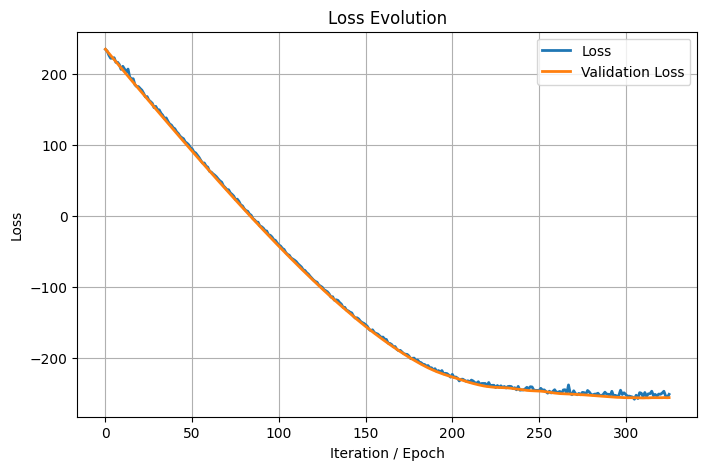

In [ ]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.5801e+00,  1.4333e+00,  1.1923e+00,  1.2841e+00,  1.3507e+00,
         1.9971e+00,  1.6468e+00,  1.2268e+00,  2.8750e+00,  1.6411e+00,
         1.6411e+00,  1.6411e+00, -9.3216e+00,  1.0397e+00,  1.1207e+00,
         1.0858e+00,  1.0623e+00,  1.6505e+00,  1.0847e+00,  1.2219e+00,
         1.7515e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00,  4.8275e-02,
        -3.5573e-03, -4.2396e-02,  1.3558e-02,  5.1815e-02, -5.2890e-02,
         3.6021e-02,  7.1310e-02, -2.9352e-02,  1.0138e-01, -6.6601e-03,
         1.2370e-01,  2.8523e-01,  3.8301e-01,  2.0832e-01,  2.4034e-01,
         1.7767e-01, -1.3305e-01, -9.6445e-02, -9.5471e-02,  1.8345e-03,
         3.1067e-01,  3.1726e-01,  2.4284e-01,  1.6009e-01,  1.6558e-01,
         2.3232e-01,  1.6573e-01, -1.3249e-01,  1.8597e-01,  1.5275e-01,
         1.7044e-01,  2.4723e-01,  1.0524e-01,  5.8974e-02,  1.3381e-01,
         4.2481e-02,  2.4740e-02,  2.3346e-02,  8.5760e-04, -1.9303e-02,
         5.8146e-02, -2.3498e-02, -3.1904e-

In [11]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [12]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [13]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [14]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [15]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [16]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.3333
KLD Gaussian Train Data:  0.0959
KLD Copula   Train Data:  -0.0012
KLD GTM      Test  Data:  1.3534
KLD Gaussian Test  Data:  0.109
KLD Copula   Test  Data:  0.0016


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [17]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

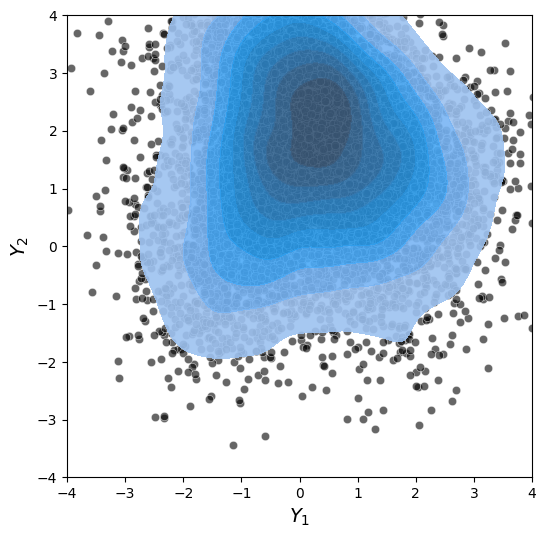

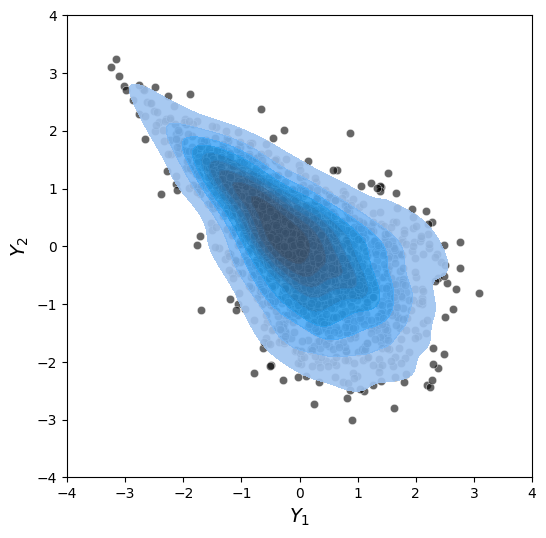

In [ ]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [19]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-general/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


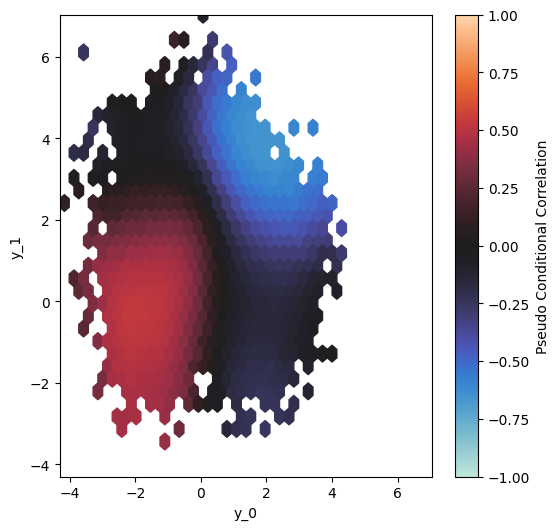

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


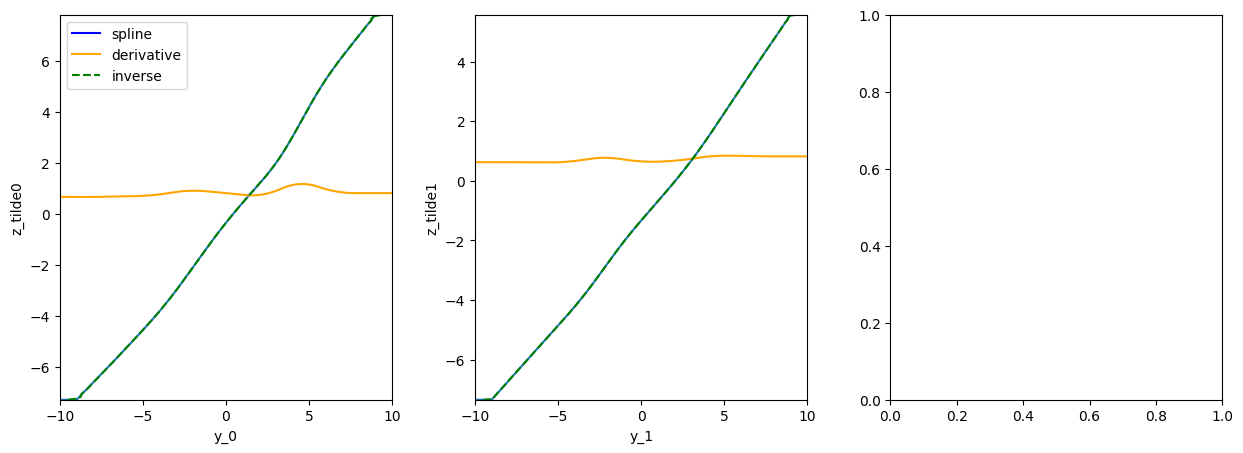

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


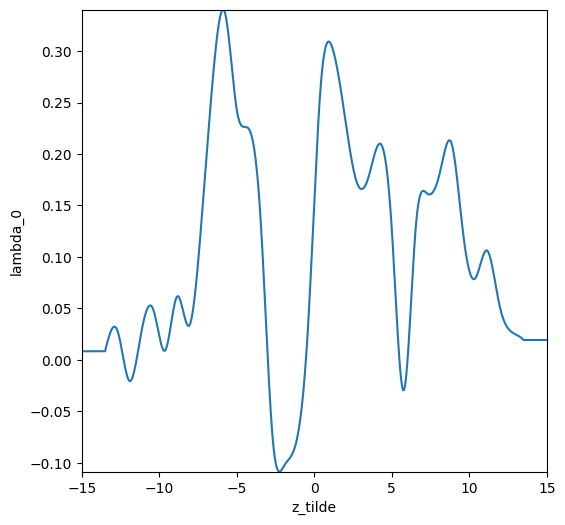

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


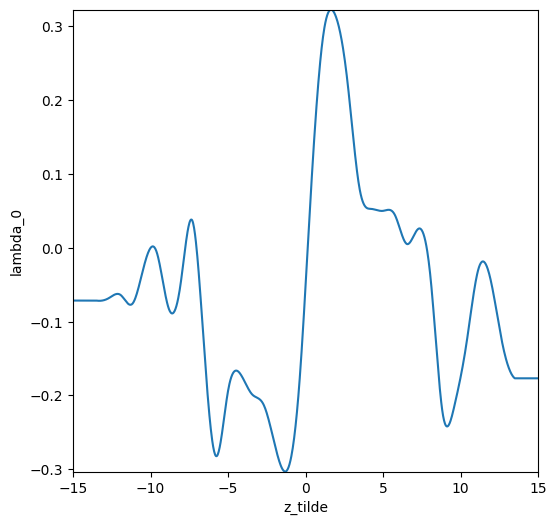

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


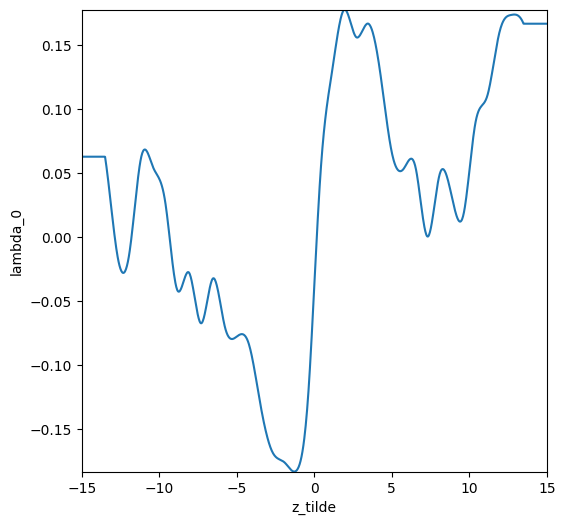

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)